# Cleaning license URLs

This notebook contains a short analysis of license URLs in REST API. In particular, I will look into how messy they are and sugests some methods for cleaning them up.

## TL;DR

* Currently in REST API we have 5,421 distinct license URLs from 1,109 domains, assigned to over 53 million DOIs. The distribution of license URL DOI count is very skewed:
  * 83.4% of DOIs with a license have one of 10 most popular license URLs
  * 99.6% of DOIs with a license have one of 100 most popular license URLs
  * 3,848 license URLs are assigned to a single DOI only
* License URLs are (unsurprisingly) messy:
  * we have malformed URLs and URLs that do not resolve properly
  * there are distinct URLs that refer to the same license 
  * some URLs point to an article or a journal page, and not a license page; such an article/journal page may or may not contain information about a license
* Because of all these problems, currently REST API cannot reliably answer even basic questions, such as how many distinct licenses there are, or how many DOIs use a particular license.
* I tested a simple license URL disambiguation method. The method can be used for:
  * suggesting an alternative, more popular license URL for a given URL provided by the user
  * cleaning up existing license URLs by merging some URLs into one license and effectively decreasing the number of distinct URLs
* After applying the disambiguation to the current license URLs:
  * the number of distinct license URLs dropped from 5,421 to 4,805
  * the number of CC license URLs dropped from 588 to 158
  * the fraction of DOIs having one of the most popular 10 license URLs increased from 83.4% to 87.8%

In [1]:
%matplotlib inline
import json
import Levenshtein as lev
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import requests
import statistics
from pandas import DataFrame

## Data

The data comes from REST API's `/licenses` route, and was downloaded on 14.03.2021. The name of the route suggests that it returns a list of licenses we have in the system, which can be then attached to the metadata of a DOI.

But this is not the case. The route aggregates license URLs from all DOIs indexed in REST API, acting like a facet, and returns a list of distinct license URLs along with their work counts. The resulting list is not curated in any way, it just reflects what people deposit as license URLs.

The following code reads this data from a file and displays 20 most common license URLs. Modify `recalculate` to `True` to get a more up-to-date version from the API.

In [2]:
recalculate = True
if recalculate:
    licenses_raw = requests.get('http://api.crossref.org/licenses').json()['message']['items']
    licenses_raw = sorted(licenses_raw, key=lambda l: l['URL'])
    licenses_raw = sorted(licenses_raw, key=lambda l: -l['work-count'])
    with open('data/licenses_raw_counts.json', 'w') as f:
        json.dump(licenses_raw, f, indent=2)

with open('data/licenses_raw_counts.json', 'r') as f:
    licenses_raw = json.load(f)
licenses_raw[:20]

[{'URL': 'https://www.elsevier.com/tdm/userlicense/1.0/',
  'work-count': 17617586},
 {'URL': 'http://www.springer.com/tdm', 'work-count': 9223353},
 {'URL': 'http://doi.wiley.com/10.1002/tdm_license_1.1',
  'work-count': 8349451},
 {'URL': 'http://journals.sagepub.com/page/policies/text-and-data-mining-license',
  'work-count': 2340799},
 {'URL': 'http://onlinelibrary.wiley.com/termsAndConditions#vor',
  'work-count': 1921554},
 {'URL': 'https://www.cambridge.org/core/terms', 'work-count': 1911442},
 {'URL': 'http://creativecommons.org/licenses/by/4.0/', 'work-count': 1239893},
 {'URL': 'https://creativecommons.org/licenses/by/4.0/', 'work-count': 909168},
 {'URL': 'http://doi.wiley.com/10.1002/tdm_license_1', 'work-count': 761016},
 {'URL': 'https://www.elsevier.com/open-access/userlicense/1.0/',
  'work-count': 742521},
 {'URL': 'http://creativecommons.org/licenses/by-nc-nd/4.0/',
  'work-count': 728278},
 {'URL': 'http://link.aps.org/licenses/aps-default-license',
  'work-count': 5

We can see one problem here immediately: multiple URLs can refer to the same license, for example all these:
* _http://creativecommons.org/licenses/by/4.0/_ (work count 1,129,303)
* _http://creativecommons.org/licenses/by/4.0_ (work count 413,650)
* _https://creativecommons.org/licenses/by/4.0_ (work count 414,446)
* _https://creativecommons.org/licenses/by/4.0/_ (work count 893,234)

refer to the same license CC-BY 4.0.

As expected, some URLs do not resolve to anything useful, for example because:
* the page is no longer available: _http://www.nrcresearchpress.com/page/about/CorporateTextAndDataMining_ (work count 184,131)
* incorrect CC license name was used (should be _by-nc_): _http://creativecommons.org/licenses/cc-by-nc/3.0_ (work count 221)
* URL contains an extra space: _https://creativecommons.org/licenses/by/NC-ND 1.0/_ (work count 1)
* URL is given along with a license name: _https://creativecommons.org/licenses/by-nc-nd/4.0/ - Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License_ (work count 1)
* a citation string is, probably by accident, attached to the URL: _http://creativecommons.org/licenses/by-nc/4.0MORAES, R. A; LIMA, Carlos A F. A pol\u00edtica de forma\u00e7\u00e3o de professores leigos no  Brasil: o PROFORMA\u00c7\u00c3O. Universidade e Sociedade, Bras\u00edlia/DF, Ano XV, n. 36, jul.  2005, p. 73-80.  ROBERTSON, Suzan L; DALE, Rog_ (work count 1)

And finally, even if the URL is correct and resolves, the website might not be dedicated to a license, for example:
* a journal's page with a mention of a license: https://ojs.unud.ac.id/index.php/sastra (work count 200)
* an article's page with a mention of a license: https://vestnik.rsmu.press/archive/2020/5/1/abstract?lang=en (work count 1)
* a journal/article page without a mention of a license: http://www.j-npcs.org/ (work count 52)
* an ORCID page https://orcid.org/0000-0002-6926-0359 (work count 1)

The main reason for all this is, of course, the fact that license URLs are deposited as free text, and with little or no validation.

And because of those issues, our systems are practically unable to answer basic questions like how many distinct licenses do scholarly papers use, how many DOIs use a given license, or which licenses are the most popular.

In total, we have more than 5 thousand distinct license URLs, and over 53 million DOIs have licenses.

In [3]:
print(len(licenses_raw))
total_work_count = sum([l['work-count'] for l in licenses_raw])
print(total_work_count)

5699
54004062


The data is (unsurprisingly) very skewed. 83.37% of all DOIs with licenses have one of the 10 most popular license URLs, and 99.60% - one of the top 100 license URLs. 3,848 license URLs appear only in a single DOI.

In [4]:
print(sum([l['work-count'] for l in licenses_raw[:10]]) / total_work_count)
print(sum([l['work-count'] for l in licenses_raw[:100]]) / total_work_count)
print(len([l for l in licenses_raw if l['work-count'] == 1]))

0.8335814257823791
0.9959640998856716
4112


This plot shows numbers of DOIs for each license URL in the data, sorted by the number of DOIs. We can clearly see how just a few license URLs cover a lot of DOIs, and a long tail of 1-DOI license URLs.

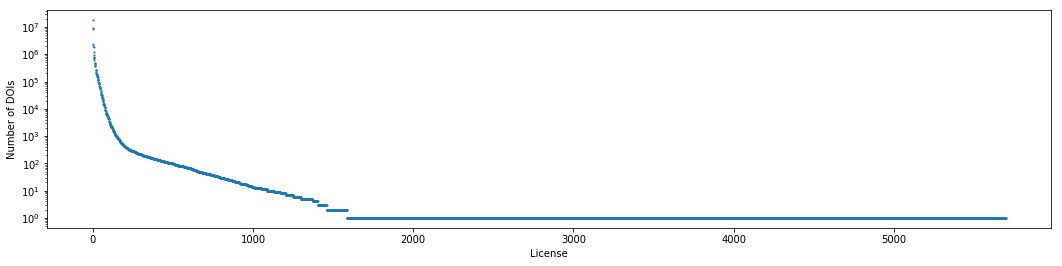

In [5]:
plt.figure(figsize=(18, 4))
plt.scatter(range(len(licenses_raw)), [license['work-count'] for license in licenses_raw], s=5, marker='.')
plt.yscale('log')
plt.xlabel('License')
plt.ylabel('Number of DOIs')
plt.show()

I will assign an identifier to each reference in the dataset, to help with further data manipulation.

In [6]:
for i, license in enumerate(licenses_raw):
    license['id'] = i
random.seed(10)
random.choice(licenses_raw)

{'URL': 'https://www.jmsr-journal.com/article/jmsr.2018.v2902.04',
 'work-count': 1,
 'id': 4680}

## Domains

I used a simple regex to extract the domain from each license URL. This will help later with license disambiguation, because if two URLs come from the same domain, there is higher probability that they represent the same license.

In [7]:
def extract_domain(url):
    domain = re.sub(r'\s+', '', url).lower()
    domain = re.sub(r'[^/]+://', '', domain)
    domain = re.sub('^www.', '', domain)
    domain = re.sub(r'/.*', '', domain)
    return domain

In [8]:
for license in licenses_raw:
    license['domain'] = extract_domain(license['URL'])
random.seed(11)
random.choice(licenses_raw)

{'URL': 'https://revistas.uautonoma.cl/index.php/ejep/article/view/1432',
 'work-count': 1,
 'id': 3705,
 'domain': 'revistas.uautonoma.cl'}

There are 1,109 distinct domains in the data:

In [9]:
domains = set(l['domain'] for l in licenses_raw)
len(domains)

1116

Which domains are most common among the license URLs?

In [10]:
domains = {}
for license in licenses_raw:
    domain = license['domain']
    if domain in domains:
        domains[domain] = [domains[domain][0] + 1, domains[domain][1]]
    else:
        domains[domain] = [1, license['work-count']]
domains = sorted([[d[0], d[1][0], d[1][1]] for d in domains.items()], key=lambda x: -x[1])
DataFrame(domains[:20], columns = ['domain', 'number of license URLs', 'max work count'])

domain  number of license URLs  max work count
0                      wseas.org                     831               2
1            creativecommons.org                     651         1239893
2     publikasi.mercubuana.ac.id                     301               4
3               jmsr-journal.com                     164               1
4          revistas.uautonoma.cl                     151               3
5                 vestnikrgmu.ru                     151               2
6           fundacioncarolina.es                     144               1
7        srinivaspublication.com                     133               4
8                       naun.org                     113               1
9    produccioncientificaluz.org                     110              37
10         fjs.fudutsinma.edu.ng                      81               1
11     e-jurnal.iainsorong.ac.id                      77               1
12  studiadecultura.up.krakow.pl                      77               1
13                       doi.org                      73            2204
14             jurnal.unej.ac.id                      72               2
15           transplantology.org                      65               2
16    e-jurnal.stainsorong.ac.id                      60               1
17    jurnal.sttmcileungsi.ac.id                      58               1
18            vestnik.rsmu.press                      55              22
19         journal.ipm2kpe.or.id                      47               1

The second column in the table shows the number of distinct license URLs that come from given domain. The third column shows the maximum work count among all those license URLs.

The domain with the most license URLs is, unsurprisingly, creativecommons.org. 650 distinct URLs is probably more than the real number of distinct CC licenses in the data, nevertheless, we would expect quite a large number of them.

72 license URLs are from doi.org domain, and the maximum work count is over 2k. URLs from doi.org with a larger work count could be DOIs of licenses. However, some of them, with lower work count, are most likely websites of journal articles, which may or may not contain the information about the license. Here is the list of all license URLs from doi.org domain:

In [11]:
[l for l in licenses_raw if l['domain'] == 'doi.org']

[{'URL': 'https://doi.org/10.1364/OA_License_v1',
  'work-count': 2204,
  'id': 116,
  'domain': 'doi.org'},
 {'URL': 'https://doi.org/10.1364/OA_License_v1#VOR-OA',
  'work-count': 986,
  'id': 146,
  'domain': 'doi.org'},
 {'URL': 'https://doi.org/10.1364/OA_License_v1#VOR',
  'work-count': 602,
  'id': 173,
  'domain': 'doi.org'},
 {'URL': 'https://doi.org/10.1128/AuthorWarrantyLicense.v1',
  'work-count': 508,
  'id': 185,
  'domain': 'doi.org'},
 {'URL': 'https://doi.org/10.37349/Open_Exploration_Crossmark_Policy',
  'work-count': 80,
  'id': 545,
  'domain': 'doi.org'},
 {'URL': 'https://doi.org/10.1364/OA_License_v1#CCBY',
  'work-count': 46,
  'id': 687,
  'domain': 'doi.org'},
 {'URL': 'https://doi.org/10.1364/OA_License_v1#AM',
  'work-count': 30,
  'id': 804,
  'domain': 'doi.org'},
 {'URL': 'https://doi.org/10.1364/OA_License_v1#am',
  'work-count': 30,
  'id': 805,
  'domain': 'doi.org'},
 {'URL': 'https://doi.org/10.1364/OA_License_v1#GOV',
  'work-count': 11,
  'id': 107

Most of domains with a lot of distinct license URLs have a very low max work count, meaning each of their license URL is assigned to 1 or 2 DOIs only. Again, this suggests those URLs are not URLs of licenses, as proper license URLs would be most likely shared among many DOIs. Here is an example:

In [12]:
[l for l in licenses_raw if l['domain'] == 'jmsr-journal.com']

[{'URL': 'https://www.jmsr-journal.com/article/jmsr.2003.v0102.01',
  'work-count': 1,
  'id': 4530,
  'domain': 'jmsr-journal.com'},
 {'URL': 'https://www.jmsr-journal.com/article/jmsr.2003.v0102.02',
  'work-count': 1,
  'id': 4531,
  'domain': 'jmsr-journal.com'},
 {'URL': 'https://www.jmsr-journal.com/article/jmsr.2003.v0102.03',
  'work-count': 1,
  'id': 4532,
  'domain': 'jmsr-journal.com'},
 {'URL': 'https://www.jmsr-journal.com/article/jmsr.2003.v0102.04',
  'work-count': 1,
  'id': 4533,
  'domain': 'jmsr-journal.com'},
 {'URL': 'https://www.jmsr-journal.com/article/jmsr.2003.v0102.05',
  'work-count': 1,
  'id': 4534,
  'domain': 'jmsr-journal.com'},
 {'URL': 'https://www.jmsr-journal.com/article/jmsr.2003.v0102.06',
  'work-count': 1,
  'id': 4535,
  'domain': 'jmsr-journal.com'},
 {'URL': 'https://www.jmsr-journal.com/article/jmsr.2004.v0201.01',
  'work-count': 1,
  'id': 4536,
  'domain': 'jmsr-journal.com'},
 {'URL': 'https://www.jmsr-journal.com/article/jmsr.2004.v0201

## Creative Commons licenses

CC licenses are quite common in the data, and are an interesting subset of licenses.

CC license URLs tend to be well structured. For example, in URL https://creativecommons.org/licenses/by/3.0/es/ we have the following structural components: type `licenses`, name `by`, version `3.0` and language `es`. Language is optional, but can be important to distinguish between https://creativecommons.org/licenses/by/3.0 and https://creativecommons.org/licenses/by/3.0/es/. In the case of URL https://creativecommons.org/publicdomain/zero/1.0/ we have type `publicdomain`, name `zero`, and version `1.0`.

CC license URLs can have additional fragments, such as "deed.en" or "legalcode". Their presence does not affect the license as such, but rather how it displayed (language of the text, human summary vs. full text).

It is easy to extract those components automatically from the URL. This could help normalise some malformed CC license URL, and also to decide whether two distinct CC URLs are in fact one license.

Here are some helper functions:

In [13]:
def lev_substr(string, substring):
    min_len = len(string)
    min_dist = lev.distance(string, substring)
    for i in range(len(string)):
        dist = lev.distance(string[:i], substring)
        if dist <= min_dist:
            min_len = i
            min_dist = dist
    return string[:min_len], min_dist

In [14]:
def remove_cc_prefix(url):
    url = re.sub(r'\s+', '', url).lower()
    url = re.sub(r'^/*(https?:/+)+', '', url)
    if not url.startswith('http://creat') and not url.startswith('https://creat'):
        c_url = re.search('(https?://creat.*)', url)
        if c_url is not None:
            url = c_url.group(1)
    substr, dist = lev_substr(url, 'creativecommons.org')
    url = re.sub(r'^/*', '', url[len(substr):])
    return url

And this function will extract the components:

In [15]:
def extract_cc_components(url):
    url = remove_cc_prefix(url)

    ltype, dist = lev_substr(url, 'licenses')
    ltype_pd, dist_pd = lev_substr(url, 'publicdomain')
    if dist_pd < dist:
        ltype, dist = ltype_pd, dist_pd
    url = re.sub(r'^/*', '', url[len(ltype):])
    
    lname = re.search('^([^/]+)/', url)
    if lname is None:
        return None
    lname = lname.group(1)
    url = re.sub(r'^/*', '', url[len(lname):])

    version = re.search('^(\d+\.\d+)', url)
    if version is None:
        return None
    version = version.group(1)
    url = re.sub(r'^/*', '', url[len(version):])

    lang = ''
    if not url.startswith('deed') and not url.startswith('legal'):
        lang = re.sub(r'/.*', '', url)
        lang = lang[:3]
        
    return {'cc-type': ltype, 'cc-name': lname, 'cc-version': version, 'cc-lang': lang}

For example:

In [16]:
extract_cc_components('https://creativecommons.org/licenses/by/3.0/es/')

{'cc-type': 'licenses', 'cc-name': 'by', 'cc-version': '3.0', 'cc-lang': 'es'}

Now I will extract the components from all CC licenses in the data:

In [17]:
def is_cc_license(url):
    return 'creative' in url.lower() or 'common' in url.lower()

for license in licenses_raw:
    if is_cc_license(license['URL']):
        components = extract_cc_components(license['URL'])
        if components is not None:
            license['cc-components'] = components
licenses_cc = [l for l in licenses_raw if 'cc-components' in l]
random.seed(11)
random.choice(licenses_cc)

{'URL': 'http://creativecommons.org/licenses/by-nc//3.0',
 'work-count': 1,
 'id': 1727,
 'domain': 'creativecommons.org',
 'cc-components': {'cc-type': 'licenses',
  'cc-name': 'by-nc',
  'cc-version': '3.0',
  'cc-lang': ''}}

In total, we have 588 distinct CC license URLs, but only 224 distinct CC license component sets:

In [18]:
def cc_to_str(comp):
    return '/'.join([comp[k] for k in ['cc-type', 'cc-name', 'cc-version', 'cc-lang']])

print(len(licenses_cc))
print(len(set([cc_to_str(l['cc-components']) for l in licenses_cc])))

589
224


## Following URLs

I will also follow all license URLs to find out what they resolve to. This will help me decide later which URLs in fact represent the same license.

This function follows a URL (and redirects) and returns status code and final URL:

In [19]:
def get_final_url(url):
    try:
        print('trying', url)
        res = requests.get(url, timeout=20, headers={'User-Agent': 'Requests'})
        return res.status_code, res.url
    except:
        pass
    return None, None

In some cases, the URL is incorrect and the status code is not 200. If this happens, the code will try several simple variants of the URL, in case a simple mistake has been made:
* URL with all whitespace removed
* lowercase URL
* URL with any extra "http(s)://" removed from the beginning (we have several cases of "http://http://domain.org/" in the data)
* if URL looks like a CC license, normalized URL composed of extracted CC components
* if URL looks like a CC license, normalized URL composed of extracted CC components, but without the language
* all substrings of the original URL starting with "http(s)://" (in case there are multiple URLs in one URL string)

In [20]:
def get_url_variants(license):
    url = license['URL']
    urls = [url]

    no_spaces = re.sub(r'\s+', '', url)
    if no_spaces not in urls:
        urls.append(no_spaces)

    lowercased = url.lower()
    if lowercased not in urls:
        urls.append(lowercased)

    extra_http = re.sub(r'^https?://https://', 'https://', re.sub(r'^https?://http://', 'http://', url))
    if extra_http not in urls:
        urls.append(extra_http)

    if 'cc-components' in license:

        comp = license['cc-components']
        if comp['cc-lang'] != '':
            from_components = 'https://creativecommons.org/' + cc_to_str(comp) + '/'
            if from_components not in urls:
                urls.append(from_components)
                
        no_lang = 'https://creativecommons.org/' + comp['cc-type'] + '/' + comp['cc-name'] + '/' + comp['cc-version'] + '/'
        if no_lang not in urls:
            urls.append(no_lang)

    url_tmp = re.sub('https://', ' https://', re.sub('http://', ' http://', url))
    fragments = url_tmp.split()
    for fragment in fragments:
        if fragment.startswith('http://') or fragment.startswith('https://'):
            if len(fragment) > 10 and fragment not in urls:
                urls.append(fragment)
        
    return urls

I will use additional URL variants only when the original one does not return 200:

In [21]:
def follow_url(license):
    urls = get_url_variants(license)
    
    status_code, final_url = get_final_url(urls[0])
    variants = [{'url': urls[0], 'status-code': status_code, 'final-url': final_url}]
    if status_code == 200:
        return variants

    for url in urls[1:]:
        status_code, final_url = get_final_url(url)
        variants.append({'url': url, 'status-code': status_code, 'final-url': final_url})
  
    return variants

And finally, I will follow URL(s) for every license in the dataset. This takes a lot of time, so here I am just reading precalculated results from a file. To calculate again for new data from `/licenses` route, change `recalculate` to `True`.

In [22]:
recalculate = True
if recalculate:
    with open('data/licenses_enriched.json', 'w') as f:
        f.write('[\n')
        for i, license in enumerate(licenses_raw):
            print(i)
            license['url-variants'] = follow_url(license)
            json.dump(license, f)
            if i == len(licenses_raw)-1:
                f.write('\n]')
            else:
                f.write(',\n')

with open('data/licenses_enriched.json', 'r') as f:
    licenses = json.load(f)

0
trying https://www.elsevier.com/tdm/userlicense/1.0/
1
trying http://www.springer.com/tdm
2
trying http://doi.wiley.com/10.1002/tdm_license_1.1
3
trying http://journals.sagepub.com/page/policies/text-and-data-mining-license
4
trying http://onlinelibrary.wiley.com/termsAndConditions#vor
5
trying https://www.cambridge.org/core/terms
6
trying http://creativecommons.org/licenses/by/4.0/
7
trying https://creativecommons.org/licenses/by/4.0/
8
trying http://doi.wiley.com/10.1002/tdm_license_1
9
trying https://www.elsevier.com/open-access/userlicense/1.0/
10
trying http://creativecommons.org/licenses/by-nc-nd/4.0/
11
trying http://link.aps.org/licenses/aps-default-license
12
trying http://iopscience.iop.org/info/page/text-and-data-mining
13
trying http://creativecommons.org/licenses/by/3.0/
14
trying https://creativecommons.org/licenses/by/4.0
15
trying http://creativecommons.org/licenses/by/4.0
16
trying https://www.scientific.net/license/TDM_Licenser.pdf
17
trying https://www.scientific.n

124
trying http://www.pnas.org/preview_site/misc/userlicense.xhtml
125
trying http://creativecommons.org/licenses/BY-SA/4.0
trying http://creativecommons.org/licenses/by-sa/4.0
trying https://creativecommons.org/licenses/by-sa/4.0/
126
trying http://creativecommons.org/
127
trying https://ajis.org/index.php/ajiss/about
128
trying https://creativecommons.org/licenses/by-nc-nd/4.0/deed.en
129
trying http://creativecommons.org/licenses/by/3.0/pl/
130
trying https://royalsociety.org/-/media/journals/author/Licence-to-Publish-20062019-final.pdf
131
trying http://www.scopemed.org/?page=license
132
trying https://www.intellectbooks.com/self-archiving#accepted-manuscript-during-embargo
133
trying https://www.intellectbooks.com/self-archiving#accepted-manuscript-post-embargo
134
trying https://www.intellectbooks.com/self-archiving#final-published-version
135
trying https://bulletin.tomsk.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://bulletin.tomsk.ru/jour/about/editorialpolici

217
trying http://creativecommons.org/licenses/by-nc-nd/3.0/de
218
trying https://creativecommons.org/share-your-work/public-domain/cc0/
219
trying https://www.jsdrm.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://www.jsdrm.ru/jour/about/editorialpolicies#openaccesspolicy
220
trying https://www.nauka-dialog.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://www.nauka-dialog.ru/jour/about/editorialpolicies#openaccesspolicy
221
trying https://creativecommons.org/licenses/by-nc-nd-license/
222
trying https://creativecommons.org/licenses/by-nc/3.0/br/
223
trying https://www.ped-perinatology.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://www.ped-perinatology.ru/jour/about/editorialpolicies#openaccesspolicy
224
trying https://vavilov.elpub.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://vavilov.elpub.ru/jour/about/editorialpolicies#openaccesspolicy
225
trying https://www.tibl-journal.com/jour/about/editorialPolicies#openAccessPoli

trying https://bulletin.esoil.ru/jour/about/editorialpolicies#openaccesspolicy
292
trying https://geology.mgri-rggru.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://geology.mgri-rggru.ru/jour/about/editorialpolicies#openaccesspolicy
293
trying https://www.epidemvac.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://www.epidemvac.ru/jour/about/editorialpolicies#openaccesspolicy
294
trying http://creativecommons.org/licenses/by-nd/3.0/de
295
trying https://creativecommons.org/licenses/by-sa/4.0/deed.de
296
trying http://creativecommons.org/licenses/by-nc-sa/3.0/br/legalcode
297
trying http://creativecommons.org/licenses/by-nc-nd/3.0/at/deed.en
298
trying http://creativecommons.org/licenses/by/3.0/deed.en_GB
299
trying https://vestnik.msal.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://vestnik.msal.ru/jour/about/editorialpolicies#openaccesspolicy
300
trying https://lim.bntu.by/jour/about/editorialPolicies#openAccessPolicy
trying https://lim.bn

361
trying https://www.vair-journal.com/jour/about/editorialPolicies#openAccessPolicy
trying https://www.vair-journal.com/jour/about/editorialpolicies#openaccesspolicy
362
trying https://gnck.elpub.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://gnck.elpub.ru/jour/about/editorialpolicies#openaccesspolicy
363
trying https://re.eltech.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://re.eltech.ru/jour/about/editorialpolicies#openaccesspolicy
364
trying https://economy.fa.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://economy.fa.ru/jour/about/editorialpolicies#openaccesspolicy
365
trying https://www.jnmp.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://www.jnmp.ru/jour/about/editorialpolicies#openaccesspolicy
366
trying https://elpub.vir.nw.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://elpub.vir.nw.ru/jour/about/editorialpolicies#openaccesspolicy
367
trying https://creativecommons.org/licenses/by-nc/3.0/au/
36

426
trying http://creativecommons.org/licenses/7by-nc-sa/4.0/deed.es
trying https://creativecommons.org/licenses/7by-nc-sa/4.0/
427
trying http://dom-hors.ru/licenzia/
428
trying https://www.medicalherald.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://www.medicalherald.ru/jour/about/editorialpolicies#openaccesspolicy
429
trying https://www.radhyg.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://www.radhyg.ru/jour/about/editorialpolicies#openaccesspolicy
430
trying https://ecoprom.misis.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://ecoprom.misis.ru/jour/about/editorialpolicies#openaccesspolicy
431
trying https://vestift.belnauka.by/jour/about/editorialPolicies#openAccessPolicy
trying https://vestift.belnauka.by/jour/about/editorialpolicies#openaccesspolicy
432
trying https://www.malignanttumors.org/jour/about/editorialPolicies#openAccessPolicy
trying https://www.malignanttumors.org/jour/about/editorialpolicies#openaccesspolicy
433
trying

498
trying http://www.sudanjp.com/?sec=licenseinfo
499
trying https://ice-snow.igras.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://ice-snow.igras.ru/jour/about/editorialpolicies#openaccesspolicy
500
trying http://creativecommons.org/licenses/by/2.5/ar/
501
trying https://cfpd.elpub.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://cfpd.elpub.ru/jour/about/editorialpolicies#openaccesspolicy
502
trying https://proceedings.gpntbsib.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://proceedings.gpntbsib.ru/jour/about/editorialpolicies#openaccesspolicy
503
trying https://vestiagr.belnauka.by/jour/about/editorialPolicies#openAccessPolicy
trying https://vestiagr.belnauka.by/jour/about/editorialpolicies#openaccesspolicy
504
trying https://www.morpholetter.com/jour/about/editorialPolicies#openAccessPolicy
trying https://www.morpholetter.com/jour/about/editorialpolicies#openaccesspolicy
505
trying http://handmicrosurgeryjournal.com/?sec=licenseinfo
50

trying https://www.sechenovmedj.com/jour/about/editorialpolicies#openaccesspolicy
574
trying https://pkp.sfu.ca/contributor-license-agreement/
575
trying https://rsp.mediar-press.net/rsp/about/editorialPolicies#openAccessPolicy
trying https://rsp.mediar-press.net/rsp/about/editorialpolicies#openaccesspolicy
576
trying https://www.biopreparations.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://www.biopreparations.ru/jour/about/editorialpolicies#openaccesspolicy
577
trying https://www.htjournal.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://www.htjournal.ru/jour/about/editorialpolicies#openaccesspolicy
578
trying https://creativecommons.org/licences/by-nc-nd/4.0
579
trying https://creativecommons.org/licenses/by-nc-sa/3.0
580
trying https://journal.scbmt.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://journal.scbmt.ru/jour/about/editorialpolicies#openaccesspolicy
581
trying http://www.ulutasmedicaljournal.com/?sec=licenseinfo
582
trying ht

647
trying http://creativecommons.org/licenses/by/3.0/legalcode
648
trying http://jist.publikasiindonesia.id/index.php/jist/copyright-notice
649
trying https://creativecommons.org/licenses/by/3.0/ec/
650
trying http://creativecommons.org/licences/by-sa/4.0
651
trying http://creativecommons.org/licenses/by-nc-nd/3.0/deed.pl
652
trying http://www.j-npcs.org/
653
trying https://creativecommons.org/licenses/byncnd-nc/4.0
trying https://creativecommons.org/licenses/byncnd-nc/4.0/
654
trying http://ejournal.upi.edu/index.php/IJAL/about/submissions#authorGuidelines
655
trying https://aari.elpub.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://aari.elpub.ru/jour/about/editorialpolicies#openaccesspolicy
656
trying https://creativecommons.org/licenses/by-nc-nd/2.0/legalcode
657
trying https://creativecommons.org/licenses/by-nc/3.0/es/
658
trying http://ejournal.arraayah.ac.id/index.php/rais/
659
trying http://www.egyseb.net/ejebz/?sec=licenseinfo
660
trying http://www.sajournalofe

trying https://www.journalpsychiatry.com/jour/about/editorialpolicies#openaccesspolicy
735
trying http://creative-commons.org/licenses/by-nc/3.0
trying https://creativecommons.org/licenses/by-nc/3.0/
736
trying http://creativecommons.org/licenses/by-nc-sa/4.0/deed.uk
737
trying http://weentechpublishers.com/journal.aspx
738
trying http://www.jbehavioralhealth.com/?sec=licenseinfo
739
trying http://yenisymposium.com//?sec=licenseinfo
740
trying https://inf.grid.by/jour/about/editorialPolicies#openAccessPolicy
trying https://inf.grid.by/jour/about/editorialpolicies#openaccesspolicy
741
trying https://vid.sav.us.es
742
trying http://creativecommons.org/licenses/by-nc-nd/4.0//
743
trying http://https://jrcrs.riphah.edu.pk/?sec=licenseinfo
trying https://jrcrs.riphah.edu.pk/?sec=licenseinfo
744
trying http://jifi.farmasi.univpancasila.ac.id/index.php/jifi/licenceterm
745
trying http://submission.schizophrenia.or.kr/main.html
746
trying http://www.sjemed.com/?sec=licenseinfo
747
trying https

830
trying https://creativecommons.org/licenses/by-nc/4.0/?ref=chooser-v1
831
trying https://creativecommons.org/licenses/by-nd/4.0/deed.en
832
trying https://www.pharmacogenetics-pharmacogenomics.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://www.pharmacogenetics-pharmacogenomics.ru/jour/about/editorialpolicies#openaccesspolicy
833
trying https://www.vestnik-donstu.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://www.vestnik-donstu.ru/jour/about/editorialpolicies#openaccesspolicy
834
trying http://ajlifesciences.com/journalinfo.php
835
trying http://creativecommons.org/licenses/by/3.0/es/deed.es
836
trying http://https://www.sjemed.com/?sec=licenseinfo
trying https://www.sjemed.com/?sec=licenseinfo
837
trying http://ijeepse.id
838
trying http://shermjournal.org/mss-submissions/copyright-author-journal-rights/
839
trying http://www.gnu.org/licenses/gpl-2.0.txt
840
trying http://www.tandfonline.com/page/terms-and-conditions#link2
841
trying https://creati

925
trying http://creativecommons.org/licenses/nd/4.0
trying https://creativecommons.org/licenses/nd/4.0/
926
trying http://ejournal.sumselprov.go.id/
927
trying http://epubs.icar.org.in/ejournal/index.php/OIJR
trying http://epubs.icar.org.in/ejournal/index.php/oijr
928
trying http://glrjournal.com/guidelines/content-license
929
trying http://journal-niss.ru/en/index.php
930
trying http://jurnal.stikes-murniteguh.ac.id
931
trying http://www.ejmaces.com/?sec=licenseinfo
932
trying http://www.ejmamr.com/?sec=licenseinfo
933
trying http://www.jcreview.com/?sec=licenseinfo
934
trying http://www.tibl-journal.com/jour/about/editorialPolicies#openAccessPolicy
trying http://www.tibl-journal.com/jour/about/editorialpolicies#openaccesspolicy
935
trying https://creativecommons.org/licenses/by-nc-nd/3.0/ch
936
trying https://creativecommons.org/licenses/by-sa/4.0/deed.id
937
trying https://medalmanac.elpub.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://medalmanac.elpub.ru/jour/abo

1021
trying https://aunarcali.edu.co/revistas/index.php/RDCES/Copyright
1022
trying https://creativecommons.org/licenses/by-nc-nd/4.0/deed.fi
1023
trying https://creativecommons.org/licenses/by-nc-nd/4.0/deed.pl
1024
trying https://creativecommons.org/licenses/by-nc-sa/3.0/deed.es_AR
1025
trying https://creativecommons.org/licenses/by-nc/4.0/deed.fi
1026
trying https://creativecommons.org/licenses/by/3.0/es/
1027
trying https://m.elewa.org/Journals/about-jab/
1028
trying https://www.budapestopenaccessinitiative.org/read
1029
trying https://www.shermjournal.org/mss-submissions/copyright-author-journal-rights/
1030
trying http://bioclima.ro/Journal.htm
1031
trying http://creativecommons.org/licences/by/4.0/legalcode
1032
trying http://ejournal.unisba.ac.id/index.php/gmhc/about/submissions#copyrightNotice
trying http://ejournal.unisba.ac.id/index.php/gmhc/about/submissions#copyrightnotice
1033
trying http://ejurnal.bppt.go.id/index.php/JBBI
1034
trying http://publication.ida.org.in/IndexM

1131
trying https://www.ijsmsjournal.org/volume3-issue6.html
1132
trying http:///journals.bsu.by/index.php/biology/about
1133
trying http://creativecommons.org/licences/by-nc-sa/3.0/
1134
trying http://creativecommons.org/licenses/by-n/4.0/
trying https://creativecommons.org/licenses/by-n/4.0/
1135
trying http://creativecommons.org/licenses/by-nc/3.0/legalcode
1136
trying http://e-journal.akpelni.ac.id/index.php/Gema-Maritim/index
1137
trying http://e-jurnal.stikesalirsyadclp.ac.id/index.php/Tens
1138
trying http://ejournal.lppm-unbaja.ac.id/index.php/jeltl
1139
trying http://ejournal.uin-suska.ac.id/index.php/peternakan/about/submissions#copyrightNotice
1140
trying http://http://arrworyza.com/journal/oldissueContent.aspx?issue_id=20039&volname=Volume%2056%20Special%20Issue%202019
trying http://http://arrworyza.com/journal/oldissuecontent.aspx?issue_id=20039&volname=volume%2056%20special%20issue%202019
trying http://arrworyza.com/journal/oldissueContent.aspx?issue_id=20039&volname=Volu

1237
trying https://ejournal.undar.ac.id/index.php/intake
1238
trying https://insam-institute.com/about/
1239
trying https://journalrheumatology.or.id/index.php/IJR
1240
trying https://journals.unihaz.ac.id/index.php/mimbar
1241
trying https://ojs.unud.ac.id/index.php/simbiosis/management/settings/distribution
1242
trying https://ojs3.mtak.hu/index.php/hungeobull/about
1243
trying https://revistasulsap.lasallep.edu.mx/index.php/xihmai/condiciones
1244
trying https://scholar.google.com/citations?user=Hn8gtf0AAAAJ&hl=en
1245
trying https://sosyolojikbaglam.org/acik-erisim-politikasi/
1246
trying https://www.copyright.gov/registration/literary-works/index.html
1247
trying https://www.criticalgamblingstudies.com/
1248
trying https://www.m.elewa.org/Journals/about-jab/
1249
trying https://www.medsim.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://www.medsim.ru/jour/about/editorialpolicies#openaccesspolicy
1250
trying https://www.revistamedica.org/index.php/rmdp/copyright
125

1346
trying https://doi.org/10.25170/jara.v14i2
1347
trying https://ejournal.unmus.ac.id/index.php/fisip/issue/view/272
1348
trying https://ejournal.unmus.ac.id/index.php/fisip/issue/view/303
1349
trying https://ejournal.unmus.ac.id/index.php/fisip/issue/view/320
1350
trying https://ejournal.unmus.ac.id/index.php/fisip/issue/view/347
1351
trying https://ejournal.unmus.ac.id/index.php/mathematics/
1352
trying https://eurekabiomedical.com
1353
trying https://journal.fateta.unipa.ac.id
1354
trying https://journal.iainlangsa.ac.id/index.php/ikhtibar
1355
trying https://journal.ubb.ac.id/index.php/stannum/index
1356
trying https://journals.telkomuniversity.ac.id/business/workflow/index/2148/5
1357
trying https://languageedu.elpub.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://languageedu.elpub.ru/jour/about/editorialpolicies#openaccesspolicy
1358
trying https://ojs.unud.ac.id/index.php/BIO
1359
trying https://ojs.unud.ac.id/index.php/simbiosis
1360
trying https://ojs.unud.a

1453
trying https://m.elewa.org/Journals/current-issue-japs/
1454
trying https://materials.international/?page_id=18
1455
trying https://revistas.uautonoma.cl/index.php/ijmss/article/view/652
1456
trying https://scholar.google.co.id/citations?hl=id&user=JFmuZd0AAAAJ
1457
trying https://web.archive.org/web/20160719003937/http://www.2w.com.br/
1458
trying https://www.acapublishing.com/home
1459
trying https://www.creativecommons.org/licenses/by-nc/4.0/
1460
trying http://co.creativecommons.org/
1461
trying http://creative%20commons.org/licenses/by-nc-sa/4.0/
trying https://creativecommons.org/licenses/by-nc-sa/4.0/
1462
trying http://creativecommons.org.br/licenses/by/4.0
trying https://creativecommons.org/.br/licenses/by/4.0/
1463
trying http://creativecommons.org/Licenses/by-nc-nd/3.0/
trying http://creativecommons.org/licenses/by-nc-nd/3.0/
trying https://creativecommons.org/licenses/by-nc-nd/3.0/
1464
trying http://creativecommons.org/by/3.0/
1465
trying http://creativecommons.org/li

1551
trying https://jurnal.pcr.ac.id/index.php/elementer/OpenAccessPolicy
1552
trying https://jurnal.unej.ac.id/index.php/KORLANTAS-JIRS/article/view/15033
1553
trying https://mirjournal.elpub.ru/jour/about/editorialPolicies#openAccessPolicy
trying https://mirjournal.elpub.ru/jour/about/editorialpolicies#openaccesspolicy
1554
trying https://ofpjournal.com/index.php/ofp/PublisherPolicies#date
1555
trying https://ojs.unud.ac.id/index.php/eol/management/importexport/plugin/QuickSubmitPlugin/saveSubmit
1556
trying https://ojs.unud.ac.id/index.php/linguistika
1557
trying https://publications.muet.edu.pk/index.php/muetrj/about/license
1558
trying https://revistadefisicamedica.es/index.php/rfm
1559
trying https://revistas.uautonoma.cl/index.php/ijmss/article/view/481
1560
trying https://revistas.uautonoma.cl/index.php/ijmss/article/view/574
1561
trying https://revistas.uautonoma.cl/index.php/ijmss/article/view/608
1562
trying https://revistas.uautonoma.cl/index.php/ijmss/article/view/632
1563

1640
trying http://baitululum.fah.uinjambi.ac.id/index.php/b_ulum/workflow/index/45/5
1641
trying http://baitululum.fah.uinjambi.ac.id/index.php/b_ulum/workflow/index/46/5
1642
trying http://baitululum.fah.uinjambi.ac.id/index.php/b_ulum/workflow/index/47/5
1643
trying http://baitululum.fah.uinjambi.ac.id/index.php/b_ulum/workflow/index/49/5
1644
trying http://baitululum.fah.uinjambi.ac.id/index.php/b_ulum/workflow/index/50/5
1645
trying http://baitululum.fah.uinjambi.ac.id/index.php/b_ulum/workflow/index/60/5
1646
trying http://bcn.iums.ac.ir/page/74/Open-Access-Policy
1647
trying http://biomedpharmajournal.org/vol11no4/the-prevalence-and-evolving-risk-factors-for-colorectal-cancer-in-the-arab-world/
1648
trying http://biota.ac.id/index.php/jb/index
1649
trying http://cajas.kz/index.php/cajas/about/privacy
1650
trying http://cetes.medicina.ufmg.br/revista/index.php/rlat/workflow/index/295/5
1651
trying http://cetes.medicina.ufmg.br/revista/index.php/rlat/workflow/index/296/5
1652
tryi

trying https://creativecommons.org/licenses/by-nc/4.0/
trying http://creativecommons.org/licenses/by-nc/
1727
trying http://creativecommons.org/licenses/by-nc//3.0
1728
trying http://creativecommons.org/licenses/by-nc/2.5/uk/)
trying https://creativecommons.org/licenses/by-nc/2.5/uk/
trying https://creativecommons.org/licenses/by-nc/2.5/
1729
trying http://creativecommons.org/licenses/by-nc/3.0/igo/legalcode
1730
trying http://creativecommons.org/licenses/by-nc/3.1/
trying https://creativecommons.org/licenses/by-nc/3.1/
1731
trying http://creativecommons.org/licenses/by-nc/3.10/
trying https://creativecommons.org/licenses/by-nc/3.10/
1732
trying http://creativecommons.org/licenses/by-nc/3.11/
trying https://creativecommons.org/licenses/by-nc/3.11/
1733
trying http://creativecommons.org/licenses/by-nc/3.12/
trying https://creativecommons.org/licenses/by-nc/3.12/
1734
trying http://creativecommons.org/licenses/by-nc/3.13/
trying https://creativecommons.org/licenses/by-nc/3.13/
1735
tryin

trying https://creativecommons.org/licenses/by/4.0/htt/
trying https://creativecommons.org/licenses/by/4.0/
trying http://creativecommons.org/licenses/by/4.0
trying http://www.clei.org/cleiej/index.php/cleiej/workflow/index/446/5#
1788
trying http://creativecommons.org/licenses/by/4.2
trying https://creativecommons.org/licenses/by/4.2/
1789
trying http://creativecommons.org/licenses/by/nc/nd
1790
trying http://creativecommons.org/licenses/by/nc/nd/4.0/
1791
trying http://creativecommons.org/licenses/by/nc/nd4.0/
1792
trying http://creativecommons.org/licenses/bync-
1793
trying http://creativecommons.org/licenses/bync-sa/3.0/
trying https://creativecommons.org/licenses/bync-sa/3.0/
1794
trying http://creativecommons.org/licenses/bync-sa/4.0/
trying https://creativecommons.org/licenses/bync-sa/4.0/
1795
trying http://creativecommons.org/licenses/cc-by-nc-nd/3.0
trying https://creativecommons.org/licenses/cc-by-nc-nd/3.0/
1796
trying http://creativecommons.org/licenses/cc-by-nc/2.0/uk/
tr

trying http://e-jurnal.stainsorong.ac.id/index.php/al-riwayah/authordashboard/submission/35
1866
trying http://e-jurnal.stainsorong.ac.id/index.php/Al-Riwayah/authorDashboard/submission/38
trying http://e-jurnal.stainsorong.ac.id/index.php/al-riwayah/authordashboard/submission/38
1867
trying http://e-jurnal.stainsorong.ac.id/index.php/Tasamuh/authorDashboard/submission/161
trying http://e-jurnal.stainsorong.ac.id/index.php/tasamuh/authordashboard/submission/161
1868
trying http://e-jurnal.stainsorong.ac.id/index.php/Tasamuh/authorDashboard/submission/162
trying http://e-jurnal.stainsorong.ac.id/index.php/tasamuh/authordashboard/submission/162
1869
trying http://e-jurnal.stainsorong.ac.id/index.php/Tasamuh/authorDashboard/submission/163
trying http://e-jurnal.stainsorong.ac.id/index.php/tasamuh/authordashboard/submission/163
1870
trying http://e-jurnal.stainsorong.ac.id/index.php/Tasamuh/authorDashboard/submission/164
trying http://e-jurnal.stainsorong.ac.id/index.php/tasamuh/authordash

1913
trying http://ejournal-iakn-manado.ac.id/index.php/putewaya
1914
trying http://ejournal.atmajaya.ac.id/index.php/perkotaan/workflow/index/948/5
1915
trying http://ejournal.iaimbima.ac.id/index.php/afidah/submissions
1916
trying http://ejournal.iaimbima.ac.id/index.php/afidah/submissions#
1917
trying http://ejournal.iaimbima.ac.id/index.php/afidah/workflow/index/513/5
1918
trying http://ejournal.iaimbima.ac.id/index.php/afidah/workflow/index/586/5
1919
trying http://ejournal.iain-surakarta.ac.id/index.php/al-araf/article/view/42
1920
trying http://ejournal.iainkendari.ac.id/zawiyah/
1921
trying http://ejournal.lppm-unbaja.ac.id/index.php/jmb
1922
trying http://ejournal.radenintan.ac.id/index.php/KALAM
1923
trying http://ejournal.radenintan.ac.id/index.php/kalam
1924
trying http://ejournal.sumselprov.go.id
1925
trying http://ejournal.uin-suka.ac.id/tarbiyah/index.php/SKIJIER/workflow/index/2388/1
1926
trying http://ejournal.unikama.ac.id/index.php/jpm/article/view/2648
1927
trying h

1988
trying http://jed.neu.edu.vn/back-issue/volume-20-number-3-december-2018/revenue-diversification-and-total-assets-in-commercial-banks-evidence-from-selected-asean-countries.373649.aspx
1989
trying http://jed.neu.edu.vn/back-issue/volume-20-number-3-december-2018/the-determinants-of-equitization-success-of-state-owned-enterprises-in-vietnam.373650.aspx
1990
trying http://jed.neu.edu.vn/back-issue/volume-20-number-3-december-2018/what-causes-financial-crisis-in-asian-countries.373648.aspx
1991
trying http://jfatwa.usim.edu.my/index.php/jfatwa/article/view/230
1992
trying http://jjeci.net/2019/10/11/jeci-copyright-form/
1993
trying http://jmbk.ekonomi-unkris.ac.id/
1994
trying http://journal.binadarma.ac.id/index.php/binabahasa
1995
trying http://journal.binadarma.ac.id/index.php/jurnaltekno/workflow/index/603/5
1996
trying http://journal.binadarma.ac.id/index.php/jurnaltekno/workflow/index/621/5
1997
trying http://journal.binadarma.ac.id/index.php/jurnaltekno/workflow/index/622/5
19

2081
trying http://jurnal.pendidikanbiologiukaw.ac.id/index.php/JIBUKAW/article/view/8
2082
trying http://jurnal.pkr.ac.id/index.php/JPK/index
2083
trying http://jurnal.radenfatah.ac.id/index.php/orbital/article/view/1861
2084
trying http://jurnal.stiebankbpdjateng.ac.id/jurnal/index.php/magisma/authorDashboard/submission/62
2085
trying http://jurnal.stiebankbpdjateng.ac.id/jurnal/index.php/magisma/authorDashboard/submission/64
2086
trying http://jurnal.stiebankbpdjateng.ac.id/jurnal/index.php/magisma/authorDashboard/submission/65
2087
trying http://jurnal.stiebankbpdjateng.ac.id/jurnal/index.php/magisma/authorDashboard/submission/66
2088
trying http://jurnal.stiebankbpdjateng.ac.id/jurnal/index.php/magisma/authorDashboard/submission/67
2089
trying http://jurnal.stiebankbpdjateng.ac.id/jurnal/index.php/magisma/authorDashboard/submission/68
2090
trying http://jurnal.stiebankbpdjateng.ac.id/jurnal/index.php/magisma/authorDashboard/submission/69
2091
trying http://jurnal.stiebankbpdjateng

2183
trying http://nscpe.com/en/site/journal/22/article/185
2184
trying http://nscpe.com/en/site/journal/22/article/186
2185
trying http://nscpe.com/en/site/journal/22/article/187
2186
trying http://nscpe.com/en/site/journal/22/article/188
2187
trying http://nscpe.com/en/site/journal/22/article/189
2188
trying http://ojs.pnb.ac.id/index.php/JASL/workflow/index/808
2189
trying http://ojs.pnb.ac.id/index.php/JBK
2190
trying http://ojs.staialfurqan.ac.id/
2191
trying http://ojs.ukmc.ac.id/index.php/JUTSI
2192
trying http://ojs.unm.ac.id/chemica/index
2193
trying http://ojs.wirabhaktimakassar.ac.id/index.php/margin-balance/information/librarians
2194
trying http://olabout.wiley.com/WileyCDA/Section/id-815641.html
2195
trying http://oncology.oapublication.com/currentissues
2196
trying http://orcid.org/0000-0002-1003-5165
2197
trying http://orcid.org/0000-0002-4531-8106
2198
trying http://orcid.org/0000-0002-9414-9994
2199
trying http://orcid.org/0000-0003-0925-1132
2200
trying http://orcid.

2288
trying http://publikasi.mercubuana.ac.id/index.php/fifo/editor/view/5798
2289
trying http://publikasi.mercubuana.ac.id/index.php/fifo/editor/view/5799
2290
trying http://publikasi.mercubuana.ac.id/index.php/fifo/editor/view/5800
2291
trying http://publikasi.mercubuana.ac.id/index.php/fifo/editor/view/5801
2292
trying http://publikasi.mercubuana.ac.id/index.php/fifo/editor/view/5802
2293
trying http://publikasi.mercubuana.ac.id/index.php/fifo/view/2935
2294
trying http://publikasi.mercubuana.ac.id/index.php/fifo/view/2937
2295
trying http://publikasi.mercubuana.ac.id/index.php/fifo/view/2938
2296
trying http://publikasi.mercubuana.ac.id/index.php/fifo/view/2939
2297
trying http://publikasi.mercubuana.ac.id/index.php/fifo/view/2940
2298
trying http://publikasi.mercubuana.ac.id/index.php/fifo/view/2941
2299
trying http://publikasi.mercubuana.ac.id/index.php/fifo/view/2942
2300
trying http://publikasi.mercubuana.ac.id/index.php/fifo/view/2943
2301
trying http://publikasi.mercubuana.ac

2391
trying http://publikasi.mercubuana.ac.id/index.php/sinergi/article/view/261
2392
trying http://publikasi.mercubuana.ac.id/index.php/sinergi/article/view/262
2393
trying http://publikasi.mercubuana.ac.id/index.php/sinergi/article/view/263
2394
trying http://publikasi.mercubuana.ac.id/index.php/sinergi/article/view/2635
2395
trying http://publikasi.mercubuana.ac.id/index.php/sinergi/article/view/264
2396
trying http://publikasi.mercubuana.ac.id/index.php/sinergi/article/view/2668
2397
trying http://publikasi.mercubuana.ac.id/index.php/sinergi/article/view/2709
2398
trying http://publikasi.mercubuana.ac.id/index.php/sinergi/article/view/2771
2399
trying http://publikasi.mercubuana.ac.id/index.php/sinergi/article/view/2826
2400
trying http://publikasi.mercubuana.ac.id/index.php/sinergi/article/view/2845
2401
trying http://publikasi.mercubuana.ac.id/index.php/sinergi/article/view/2881
2402
trying http://publikasi.mercubuana.ac.id/index.php/sinergi/article/view/2921
2403
trying http://p

2492
trying http://publikasi.mercubuana.ac.id/index.php/virtuvian/article/view/6197
2493
trying http://publikasi.mercubuana.ac.id/index.php/virtuvian/article/view/6216
2494
trying http://publikasi.mercubuana.ac.id/index.php/virtuvian/article/view/6312
2495
trying http://publikasi.mercubuana.ac.id/index.php/virtuvian/article/view/6414
2496
trying http://publikasi.mercubuana.ac.id/index.php/virtuvian/article/view/6436
2497
trying http://publikasi.mercubuana.ac.id/index.php/virtuvian/article/view/6584
2498
trying http://publikasi.mercubuana.ac.id/index.php/virtuvian/article/view/6594
2499
trying http://publikasi.mercubuana.ac.id/index.php/virtuvian/article/view/6653
2500
trying http://publikasi.mercubuana.ac.id/index.php/virtuvian/article/view/6654
2501
trying http://publikasi.mercubuana.ac.id/index.php/virtuvian/article/view/7031
2502
trying http://publikasi.mercubuana.ac.id/index.php/virtuvian/article/view/7069
2503
trying http://publikasi.mercubuana.ac.id/index.php/virtuvian/article/vi

2608
trying http://studiadecultura.up.krakow.pl/article/view/4633
2609
trying http://studiadecultura.up.krakow.pl/article/view/4634
2610
trying http://studiadecultura.up.krakow.pl/article/view/4635
2611
trying http://studiadecultura.up.krakow.pl/article/view/4636
2612
trying http://studiadecultura.up.krakow.pl/article/view/4637
2613
trying http://studiadecultura.up.krakow.pl/article/view/4638
2614
trying http://studiadecultura.up.krakow.pl/article/view/4745
2615
trying http://studiadecultura.up.krakow.pl/article/view/4749
2616
trying http://studiadecultura.up.krakow.pl/article/view/4750
2617
trying http://studiadecultura.up.krakow.pl/article/view/4752
2618
trying http://studiadecultura.up.krakow.pl/article/view/4753
2619
trying http://studiadecultura.up.krakow.pl/article/view/4754
2620
trying http://studiadecultura.up.krakow.pl/article/view/4756
2621
trying http://studiadecultura.up.krakow.pl/article/view/4758
2622
trying http://studiadecultura.up.krakow.pl/article/view/4761
2623
tryin

trying http://www.ametsoc.org/of-record"start_date="2018-02-02"&gt;http://www.ametsoc.org/PUBSReuseLicenses
trying http://www.ametsoc.org/of-record" start_date="2018-02-02"&gt;http://www.ametsoc.org/pubsreuselicenses
trying http://www.ametsoc.org/of-record"
trying http://www.ametsoc.org/PUBSReuseLicenses
2721
trying http://www.asiaamericalatina.org/wp-content/uploads/2019/04/AAL_6_PEDROSA_NOCE_UN_A%C3%91O.pdf
2722
trying http://www.biomed.cas.cz/physiolres/policy.htm
2723
trying http://www.biotech-asia.org/vol15no2/stability-and-mobility-of-lid-lipmnk-in-acetonitrile-by-molecular-dynamics-simulations-approach/
2724
trying http://www.biotech-asia.org/vol15no4/ex-vivo-anaerobic-digestion-of-non-palatable-pastoral-plant-toward-non-traditional-animal-feed/
2725
trying http://www.callosumneurology.org/index.php/callosumneurology/user/authorizationDenied?message=user.authorization.invalidIssue
2726
trying http://www.caribbeanherpetology.org/about.php?mob=y
2727
trying http://www.creativecomm

2815
trying http://www.thisisalicense.org
2816
trying http://www.vtg.mod.gov.rs/copyright-notice-and-self-archiving-policy.html
2817
trying http://www.weentechpublishers.com/view.aspx?jid=2cd47399-9f73-4dd7-b17d-c7e7ecd1a8bd
2818
trying http://www.wseas.org/multimedia/journals/circuits/2020/a665101-042.pdf
2819
trying http://www.wseas.org/multimedia/journals/economics/2021/a245107-1193.pdf
2820
trying http://www.wseas.org/multimedia/journals/economics/2021/a265107-1214.pdf
2821
trying http://www.wseas.org/multimedia/journals/economics/2021/a485107-010(2021).pdf
2822
trying httpS://creativecommons.org/licenses/by-nc/4.0/
2823
trying https:// Creative Comons Atribute 4.0 International License
trying https://CreativeComonsAtribute4.0InternationalLicense
trying https:// creative comons atribute 4.0 international license
2824
trying https://academic.oup.com/journals/pages/open_access/fundr_policies/chorus/standard_publication_model
2825
trying https://aipublisher.org/?smd_process_download=1

trying https://creativecommons.org/licenses/by-nc-nd/4.0/-cr/
trying https://creativecommons.org/licenses/by-nc-nd/4.0/
2907
trying https://creativecommons.org/licenses/by-nc-nd/4.0/deed.en_GB
2908
trying https://creativecommons.org/licenses/by-nc-nd/4.0/deed.es_EShttps://creativecommons.org/licenses/by-nc-nd/4.0/deed.es_ES
trying https://creativecommons.org/licenses/by-nc-nd/4.0/deed.es_eshttps://creativecommons.org/licenses/by-nc-nd/4.0/deed.es_es
trying https://creativecommons.org/licenses/by-nc-nd/4.0/
trying https://creativecommons.org/licenses/by-nc-nd/4.0/deed.es_ES
2909
trying https://creativecommons.org/licenses/by-nc-nd/4.0/deed.nl
2910
trying https://creativecommons.org/licenses/by-nc-nd/4.0/pl/legalcode
2911
trying https://creativecommons.org/licenses/by-nc-nd/4.0/sa
trying https://creativecommons.org/licenses/by-nc-nd/4.0/sa/
trying https://creativecommons.org/licenses/by-nc-nd/4.0/
2912
trying https://creativecommons.org/licenses/by-nc-sa/
2913
trying https://creativecomm

trying https://drive.google.com/file/d/1-iluxmp2sl7fdktxiavnnclel9a-gkom/view?usp=sharing
2993
trying https://drive.google.com/file/d/10VCjudZ7rrNamo5Ini-jn-ekcAwWI9GE/view?usp=sharing
trying https://drive.google.com/file/d/10vcjudz7rrnamo5ini-jn-ekcawwi9ge/view?usp=sharing
2994
trying https://drive.google.com/file/d/11sT6c4TfokrCYuH_k9wfqKEuy5_J9GGv/view?usp=sharing
trying https://drive.google.com/file/d/11st6c4tfokrcyuh_k9wfqkeuy5_j9ggv/view?usp=sharing
2995
trying https://drive.google.com/file/d/11utjojUD_Yimio5nB2t1di3DMDIQ91YG/view?usp=sharing
trying https://drive.google.com/file/d/11utjojud_yimio5nb2t1di3dmdiq91yg/view?usp=sharing
2996
trying https://drive.google.com/file/d/12I5qFeenrlOFE8n5A18cqdipgJxWrF2F/view?usp=sharing
trying https://drive.google.com/file/d/12i5qfeenrlofe8n5a18cqdipgjxwrf2f/view?usp=sharing
2997
trying https://drive.google.com/file/d/13u-GPzZramQYAwmRsMZ3nc5A2VDKyXSs/view?usp=sharing
trying https://drive.google.com/file/d/13u-gpzzramqyawmrsmz3nc5a2vdkyxss/vi

trying https://e-jurnal.iainsorong.ac.id/index.php/al-riwayah/authordashboard/submission/269
3040
trying https://e-jurnal.iainsorong.ac.id/index.php/Al-Riwayah/authorDashboard/submission/270
trying https://e-jurnal.iainsorong.ac.id/index.php/al-riwayah/authordashboard/submission/270
3041
trying https://e-jurnal.iainsorong.ac.id/index.php/Al-Riwayah/authorDashboard/submission/271
trying https://e-jurnal.iainsorong.ac.id/index.php/al-riwayah/authordashboard/submission/271
3042
trying https://e-jurnal.iainsorong.ac.id/index.php/Al-Riwayah/authorDashboard/submission/272
trying https://e-jurnal.iainsorong.ac.id/index.php/al-riwayah/authordashboard/submission/272
3043
trying https://e-jurnal.iainsorong.ac.id/index.php/Al-Riwayah/authorDashboard/submission/273
trying https://e-jurnal.iainsorong.ac.id/index.php/al-riwayah/authordashboard/submission/273
3044
trying https://e-jurnal.iainsorong.ac.id/index.php/Al-Riwayah/authorDashboard/submission/274
trying https://e-jurnal.iainsorong.ac.id/inde

3083
trying https://e-jurnal.iainsorong.ac.id/index.php/Transformasi/authorDashboard/submission/310
trying https://e-jurnal.iainsorong.ac.id/index.php/transformasi/authordashboard/submission/310
3084
trying https://e-jurnal.iainsorong.ac.id/index.php/Transformasi/authorDashboard/submission/311
trying https://e-jurnal.iainsorong.ac.id/index.php/transformasi/authordashboard/submission/311
3085
trying https://e-jurnal.iainsorong.ac.id/index.php/Transformasi/authorDashboard/submission/312
trying https://e-jurnal.iainsorong.ac.id/index.php/transformasi/authordashboard/submission/312
3086
trying https://e-jurnal.iainsorong.ac.id/index.php/Transformasi/authorDashboard/submission/313
trying https://e-jurnal.iainsorong.ac.id/index.php/transformasi/authordashboard/submission/313
3087
trying https://e-jurnal.iainsorong.ac.id/index.php/Transformasi/authorDashboard/submission/314
trying https://e-jurnal.iainsorong.ac.id/index.php/transformasi/authordashboard/submission/314
3088
trying https://e-jur

3133
trying https://extempore.info/component/content/article/9-joornal/2020-zamorozheni-iaitseklityny.html?Itemid=141
3134
trying https://fdp.rsmu.ru/en/site/journal/21/article/177
3135
trying https://fdp.rsmu.ru/en/site/journal/21/article/178
3136
trying https://fdp.rsmu.ru/en/site/journal/21/article/179
3137
trying https://fdp.rsmu.ru/en/site/journal/21/article/180
3138
trying https://fdp.rsmu.ru/en/site/journal/21/article/181
3139
trying https://fdp.rsmu.ru/en/site/journal/21/article/182
3140
trying https://fdp.rsmu.ru/en/site/journal/23/article/190
3141
trying https://fdp.rsmu.ru/en/site/journal/23/article/191
3142
trying https://fdp.rsmu.ru/en/site/journal/23/article/192
3143
trying https://fdp.rsmu.ru/en/site/journal/23/article/193
3144
trying https://fdp.rsmu.ru/en/site/journal/23/article/194
3145
trying https://fdp.rsmu.ru/en/site/journal/23/article/195
3146
trying https://fjs.fudutsinma.edu.ng/index.php/fjs/$$$call$$$/api/file/file-api/download-file?fileId=405&revision=1&submi

3196
trying https://fjs.fudutsinma.edu.ng/index.php/fjs/$$$call$$$/api/file/file-api/download-file?fileId=659&revision=1&submissionId=227&stageId=5
3197
trying https://fjs.fudutsinma.edu.ng/index.php/fjs/$$$call$$$/api/file/file-api/download-file?fileId=662&revision=1&submissionId=228&stageId=5
3198
trying https://fjs.fudutsinma.edu.ng/index.php/fjs/$$$call$$$/api/file/file-api/download-file?fileId=665&revision=1&submissionId=229&stageId=5
3199
trying https://fjs.fudutsinma.edu.ng/index.php/fjs/$$$call$$$/api/file/file-api/download-file?fileId=668&revision=1&submissionId=230&stageId=5
3200
trying https://fjs.fudutsinma.edu.ng/index.php/fjs/$$$call$$$/api/file/file-api/download-file?fileId=670&revision=1&submissionId=140&stageId=5
3201
trying https://fjs.fudutsinma.edu.ng/index.php/fjs/$$$call$$$/api/file/file-api/download-file?fileId=673&revision=1&submissionId=231&stageId=5
3202
trying https://fjs.fudutsinma.edu.ng/index.php/fjs/$$$call$$$/api/file/file-api/download-file?fileId=676&re

3273
trying https://journal.ipm2kpe.or.id/index.php/ALIGNMENT/article/view/743
3274
trying https://journal.ipm2kpe.or.id/index.php/ALIGNMENT/article/view/752
3275
trying https://journal.ipm2kpe.or.id/index.php/COSTING/article/view/360
3276
trying https://journal.ipm2kpe.or.id/index.php/COSTING/article/view/547
3277
trying https://journal.ipm2kpe.or.id/index.php/COSTING/article/view/548
3278
trying https://journal.ipm2kpe.or.id/index.php/COSTING/article/view/554
3279
trying https://journal.ipm2kpe.or.id/index.php/COSTING/article/view/557
3280
trying https://journal.ipm2kpe.or.id/index.php/COSTING/article/view/558
3281
trying https://journal.ipm2kpe.or.id/index.php/COSTING/article/view/560
3282
trying https://journal.ipm2kpe.or.id/index.php/COSTING/article/view/562
3283
trying https://journal.ipm2kpe.or.id/index.php/COSTING/article/view/563
3284
trying https://journal.ipm2kpe.or.id/index.php/COSTING/article/view/565
3285
trying https://journal.ipm2kpe.or.id/index.php/COSTING/article/view

3380
trying https://jport.co/content/uploads/pdf/4121046_259-263.pdf
3381
trying https://jport.co/content/uploads/pdf/4283534_463-479.pdf
3382
trying https://jport.co/content/uploads/pdf/4630917_287-303.pdf
3383
trying https://jport.co/content/uploads/pdf/4698735_149-163.pdf
3384
trying https://jport.co/content/uploads/pdf/495985_439-461.pdf
3385
trying https://jport.co/content/uploads/pdf/5021116_413-437.pdf
3386
trying https://jport.co/content/uploads/pdf/5100544_273-285.pdf
3387
trying https://jport.co/content/uploads/pdf/5362066_%D9%87%D8%A7%D9%84%D9%87%20%D9%85%D8%AD%D9%85%D8%AF%20%D8%B9%D8%A8%D8%AF.docx%201.pdf
trying https://jport.co/content/uploads/pdf/5362066_%d9%87%d8%a7%d9%84%d9%87%20%d9%85%d8%ad%d9%85%d8%af%20%d8%b9%d8%a8%d8%af.docx%201.pdf
3388
trying https://jport.co/content/uploads/pdf/6103719_%D9%85%D9%87%D9%86%D8%AF%20%D9%85%D8%AC%D9%8A%D8%AF%20%D8%B1%D8%B4%D9%8A%D8%AF.pdf
trying https://jport.co/content/uploads/pdf/6103719_%d9%85%d9%87%d9%86%d8%af%20%d9%85%d8%ac%d9%8a

3481
trying https://jurnal.unej.ac.id/index.php/KORLANTAS-JIRS/article/view/15017
3482
trying https://jurnal.unej.ac.id/index.php/KORLANTAS-JIRS/article/view/15019
3483
trying https://jurnal.unej.ac.id/index.php/KORLANTAS-JIRS/article/view/15022
3484
trying https://jurnal.unej.ac.id/index.php/KORLANTAS-JIRS/article/view/15024
3485
trying https://jurnal.unej.ac.id/index.php/KORLANTAS-JIRS/article/view/15025
3486
trying https://jurnal.unej.ac.id/index.php/KORLANTAS-JIRS/article/view/15026
3487
trying https://jurnal.unej.ac.id/index.php/KORLANTAS-JIRS/article/view/15027
3488
trying https://jurnal.unej.ac.id/index.php/KORLANTAS-JIRS/article/view/15032
3489
trying https://jurnal.unej.ac.id/index.php/KORLANTAS-JIRS/article/view/15035
3490
trying https://jurnal.unej.ac.id/index.php/KORLANTAS-JIRS/article/view/15037
3491
trying https://jurnal.unej.ac.id/index.php/KORLANTAS-JIRS/article/view/15038
3492
trying https://jurnal.unej.ac.id/index.php/KORLANTAS-JIRS/article/view/15041
3493
trying http

3592
trying https://produccioncientificaluz.org/index.php/cuestiones/article/view/33309/35044
3593
trying https://produccioncientificaluz.org/index.php/cuestiones/article/view/33310/35045
3594
trying https://produccioncientificaluz.org/index.php/cuestiones/article/view/33311/35046
3595
trying https://produccioncientificaluz.org/index.php/cuestiones/article/view/33312/35047
3596
trying https://produccioncientificaluz.org/index.php/cuestiones/article/view/33313/35048
3597
trying https://produccioncientificaluz.org/index.php/cuestiones/article/view/33314/35049
3598
trying https://produccioncientificaluz.org/index.php/cuestiones/article/view/33316/35050
3599
trying https://produccioncientificaluz.org/index.php/cuestiones/article/view/33317/35051
3600
trying https://produccioncientificaluz.org/index.php/cuestiones/article/view/33318/35052
3601
trying https://produccioncientificaluz.org/index.php/cuestiones/article/view/33319/35053
3602
trying https://produccioncientificaluz.org/index.php/cu

3682
trying https://produccioncientificaluz.org/index.php/rluz/article/view/34999/36998
3683
trying https://publications.muet.edu.pk/index.php/muetrj/article/view/1691
3684
trying https://raap.culturalhosting.com.es
3685
trying https://rcin.org.pl/igipz/Content/157606/WA51_189945_r2020-t92-z4_Przeg-Geogr-Szejgiec.pdf
3686
trying https://rdw.rowan.edu/cgi/preview_article.cgi?article=1035&context=crjcsm
3687
trying https://reccmi.redaccioncto.com/course/view.php?id=22
3688
trying https://rej.uchile.cl/
3689
trying https://research-publishing.net/manuscript?10.14705/rpnet.2018.jve.3
3690
trying https://resources.today/en/08ECOR419.html
3691
trying https://retic.redaccioncto.com/course/view.php?id=19
3692
trying https://revistaconsinter.com/revistas/ano-v-numero-ix/direito-privado/a-instrumentalidade-da-empresa-individual-de-responsabilidade-limitada-eireli/
3693
trying https://revistadefisicamedica.es/
3694
trying https://revistaeletronica.icmbio.gov.br/index.php/BioBR/workflow/index/1682

3789
trying https://revistas.uautonoma.cl/index.php/rjyd/article/view/1362
3790
trying https://revistas.uautonoma.cl/index.php/rjyd/article/view/257
3791
trying https://revistas.uautonoma.cl/index.php/rjyd/article/view/265
3792
trying https://revistas.uautonoma.cl/index.php/rjyd/article/view/266
3793
trying https://revistas.uautonoma.cl/index.php/rjyd/article/view/267
3794
trying https://revistas.uautonoma.cl/index.php/rjyd/article/view/268
3795
trying https://revistas.uautonoma.cl/index.php/rjyd/article/view/269
3796
trying https://revistas.uautonoma.cl/index.php/rjyd/article/view/270
3797
trying https://revistas.uautonoma.cl/index.php/rjyd/article/view/271
3798
trying https://revistas.uautonoma.cl/index.php/rjyd/article/view/272
3799
trying https://revistas.uautonoma.cl/index.php/rjyd/article/view/273
3800
trying https://revistas.uautonoma.cl/index.php/rjyd/article/view/274
3801
trying https://revistas.uautonoma.cl/index.php/rjyd/article/view/275
3802
trying https://revistas.uautonom

3889
trying https://srinivaspublication.com/wp-content/uploads/2019/01/8.Citizen_FullPaper.pdf
3890
trying https://srinivaspublication.com/wp-content/uploads/2019/01/8.StudyMaterials_FullPaper.pdf
3891
trying https://srinivaspublication.com/wp-content/uploads/2019/01/9.QualityEnhancement_FullPaper.pdf
3892
trying https://srinivaspublication.com/wp-content/uploads/2019/02/1.ChangingLandScape_FullPaper-1.pdf
3893
trying https://srinivaspublication.com/wp-content/uploads/2019/02/1.EnergyEfficiency_FullPaper.pdf
3894
trying https://srinivaspublication.com/wp-content/uploads/2019/02/1.FearlessResearch_FullPaper..pdf
3895
trying https://srinivaspublication.com/wp-content/uploads/2019/02/10.FacultyPerformance_FullPaper-1.pdf
3896
trying https://srinivaspublication.com/wp-content/uploads/2019/02/10.VCResearch_Abstract-1.pdf
3897
trying https://srinivaspublication.com/wp-content/uploads/2019/02/11.ChangeDivorce_FullPaper-1.pdf
3898
trying https://srinivaspublication.com/wp-content/uploads/2019/

3968
trying https://srinivaspublication.com/wp-content/uploads/2020/09/2.GISEnv_FullPaper.pdf
3969
trying https://srinivaspublication.com/wp-content/uploads/2020/09/8.-BloodPressure_FullPaper.pdf
3970
trying https://srinivaspublication.com/wp-content/uploads/2020/10/15.Airport-Nepal_Fullpaper.pdf
3971
trying https://srinivaspublication.com/wp-content/uploads/2020/10/17.-Quality-of-service_Fullpaper.pdf
3972
trying https://srinivaspublication.com/wp-content/uploads/2020/11/16.-Number-of-Bidders_Fullpaper.pdf
3973
trying https://srinivaspublication.com/wp-content/uploads/2020/11/18.-Compilation-Validation-Final_Fullpaper.pdf
3974
trying https://srinivaspublication.com/wp-content/uploads/2020/11/19.-Delayed-Gratification-in-Retail_Fullpaper.pdf
3975
trying https://srinivaspublication.com/wp-content/uploads/2020/11/20.-Impact-of-COVID-19_Fullpaper.pdf
3976
trying https://srinivaspublication.com/wp-content/uploads/2020/12/21.-Strategies-to-Implement-NEP-2020_Fullpaper.pdf
3977
trying https:

4063
trying https://vestnik.rsmu.press/archive/2021/1/5/abstract?lang=en
4064
trying https://vestnik.rsmu.press/archive/2021/1/5/abstract?lang=ru
4065
trying https://vestnik.rsmu.press/archive/2021/1/6/abstract?lang=en
4066
trying https://vestnik.rsmu.press/archive/2021/1/6/abstract?lang=ru
4067
trying https://vestnik.rsmu.press/archive/2021/1/7/abstract?lang=en
4068
trying https://vestnik.rsmu.press/archive/2021/1/7/abstract?lang=ru
4069
trying https://vestnik.rsmu.press/archive/2021/1/8/abstract?lang=en
4070
trying https://vestnik.rsmu.press/archive/2021/1/8/abstract?lang=ru
4071
trying https://vestnik.rsmu.press/archive/2021/1/9/abstract?lang=en
4072
trying https://vestnik.rsmu.press/archive/2021/1/9/abstract?lang=ru
4073
trying https://vestnik.rsmu.press/archive/2021/2/1/abstract?lang=en
4074
trying https://vestnik.rsmu.press/archive/2021/2/1/abstract?lang=ru
4075
trying https://vestnikksucta.kg/wp-content/uploads/2019/06/Tom1.pdf
4076
trying https://vestnikramn.spr-journal.ru/jour

4181
trying https://vestnikrgmu.ru/archive/2020/2/7/abstract?lang=ru
4182
trying https://vestnikrgmu.ru/archive/2020/2/8/abstract?lang=en
4183
trying https://vestnikrgmu.ru/archive/2020/2/8/abstract?lang=ru
4184
trying https://vestnikrgmu.ru/archive/2020/2/9/abstract?lang=en
4185
trying https://vestnikrgmu.ru/archive/2020/2/9/abstract?lang=ru
4186
trying https://vestnikrgmu.ru/archive/2020/3/1/abstract?lang=en
4187
trying https://vestnikrgmu.ru/archive/2020/3/1/abstract?lang=ru
4188
trying https://vestnikrgmu.ru/archive/2020/3/10/abstract?lang=en
4189
trying https://vestnikrgmu.ru/archive/2020/3/10/abstract?lang=ru
4190
trying https://vestnikrgmu.ru/archive/2020/3/11/abstract?lang=en
4191
trying https://vestnikrgmu.ru/archive/2020/3/11/abstract?lang=ru
4192
trying https://vestnikrgmu.ru/archive/2020/3/12/abstract?lang=en
4193
trying https://vestnikrgmu.ru/archive/2020/3/12/abstract?lang=ru
4194
trying https://vestnikrgmu.ru/archive/2020/3/13/abstract?lang=en
4195
trying https://vestnik

4291
trying https://www.eumed.net/es/revistas/oidles/vol-14-no-29-diciembre-2020/produtor-rural-irrigante
4292
trying https://www.eumed.net/es/revistas/turydes/vol-13-no-29-diciembre-dezembro-2020/experiencia-turistica
4293
trying https://www.eumed.net/es/revistas/turydes/vol-13-no-29-diciembre-dezembro-2020/hospedagem-ambientalmente-sustentaveis
4294
trying https://www.eumed.net/es/revistas/turydes/vol-13-no-29-diciembre-dezembro-2020/museo-loja
4295
trying https://www.eumed.net/es/revistas/turydes/vol-13-no-29-diciembre-dezembro-2020/paisaje-agricola-mendoza
4296
trying https://www.eumed.net/es/revistas/turydes/vol-13-no-29-diciembre-dezembro-2020/playas-elsalvador
4297
trying https://www.eumed.net/es/revistas/turydes/vol-13-no-29-diciembre-dezembro-2020/riscos-viagens-covid19
4298
trying https://www.eumed.net/es/revistas/turydes/vol-13-no-29-diciembre-dezembro-2020/turismo-aventura-quixada
4299
trying https://www.eurekaselect.com/180378/article
4300
trying https://www.foodandnutriti

4422
trying https://www.fundacioncarolina.es/dt_fc_33/
4423
trying https://www.fundacioncarolina.es/dt_fc_34/
4424
trying https://www.fundacioncarolina.es/dt_fc_35/
4425
trying https://www.fundacioncarolina.es/dt_fc_36/
4426
trying https://www.fundacioncarolina.es/dt_fc_37/
4427
trying https://www.fundacioncarolina.es/dt_fc_38/
4428
trying https://www.fundacioncarolina.es/dt_fc_39/
4429
trying https://www.fundacioncarolina.es/dt_fc_40/
4430
trying https://www.fundacioncarolina.es/dt_fc_41/
4431
trying https://www.fundacioncarolina.es/dt_fc_42/
4432
trying https://www.fundacioncarolina.es/dt_fc_43/
4433
trying https://www.fundacioncarolina.es/dt_fc_44/
4434
trying https://www.fundacioncarolina.es/dt_fc_especial/
4435
trying https://www.fundacioncarolina.es/dt_fc_especial2/
4436
trying https://www.fundacioncarolina.es/dt_fc_especial3/
4437
trying https://www.fundacioncarolina.es/estudios-y-analisis/publicaciones/analisis-carolina/
4438
trying https://www.fundacioncarolina.es/estudios-y-a

4511
trying https://www.ineteconomics.org/research/research-papers/inclusive-american-economic-history-containing-slaves-freedmen-jim-crow-laws-and-the-great-migration
4512
trying https://www.ineteconomics.org/research/research-papers/is-the-most-unproductive-firm-the-foundation-of-the-most-efficient-economy-penrosian-learning-confronts-the-neoclassical-fallacy
4513
trying https://www.ineteconomics.org/research/research-papers/modeling-myths-on-the-need-for-dynamic-realism-in-dice-and-other-equilibrium-models-of-global-climate-mitigation
4514
trying https://www.ineteconomics.org/research/research-papers/modigliani-meets-minsky-inequality-debt-and-financial-fragility-in-america-1950-2016
4515
trying https://www.ineteconomics.org/research/research-papers/payment-vs-funding-the-law-of-reflux-for-today
4516
trying https://www.ineteconomics.org/research/research-papers/payroll-share-real-wage-and-labor-productivity-across-us-states
4517
trying https://www.ineteconomics.org/research/research

4614
trying https://www.jmsr-journal.com/article/jmsr.2012.v1801.02
4615
trying https://www.jmsr-journal.com/article/jmsr.2012.v1801.03
4616
trying https://www.jmsr-journal.com/article/jmsr.2012.v1801.04
4617
trying https://www.jmsr-journal.com/article/jmsr.2012.v1801.05
4618
trying https://www.jmsr-journal.com/article/jmsr.2012.v1902.01
4619
trying https://www.jmsr-journal.com/article/jmsr.2012.v1902.02
4620
trying https://www.jmsr-journal.com/article/jmsr.2012.v1902.03
4621
trying https://www.jmsr-journal.com/article/jmsr.2012.v1902.04
4622
trying https://www.jmsr-journal.com/article/jmsr.2012.v1902.05
4623
trying https://www.jmsr-journal.com/article/jmsr.2012.v1902.06
4624
trying https://www.jmsr-journal.com/article/jmsr.2012.v1902.07
4625
trying https://www.jmsr-journal.com/article/jmsr.2013.v2001.01
4626
trying https://www.jmsr-journal.com/article/jmsr.2013.v2001.02
4627
trying https://www.jmsr-journal.com/article/jmsr.2013.v2001.03
4628
trying https://www.jmsr-journal.com/article

4729
trying https://www.naun.org/main/NAUN/circuitssystemssignal/2021/a042005-002(2021).pdf
4730
trying https://www.naun.org/main/NAUN/circuitssystemssignal/2021/a082005-004(2021).pdf
4731
trying https://www.naun.org/main/NAUN/circuitssystemssignal/2021/a102005-005(2021).pdf
4732
trying https://www.naun.org/main/NAUN/circuitssystemssignal/2021/a122005-006(2021).pdf
4733
trying https://www.naun.org/main/NAUN/circuitssystemssignal/2021/a142005-007(2021).pdf
4734
trying https://www.naun.org/main/NAUN/circuitssystemssignal/2021/a162005-008(2021).pdf
4735
trying https://www.naun.org/main/NAUN/circuitssystemssignal/2021/a182005-009(2021).pdf
4736
trying https://www.naun.org/main/NAUN/circuitssystemssignal/2021/a202005-010(2021).pdf
4737
trying https://www.naun.org/main/NAUN/circuitssystemssignal/2021/a222005-011(2021).pdf
4738
trying https://www.naun.org/main/NAUN/circuitssystemssignal/2021/a242005-012(2021).pdf
4739
trying https://www.naun.org/main/NAUN/circuitssystemssignal/2021/a262005-01

4824
trying https://www.redgdps.org/cuadernos/enfoque-cardio-metabolico-del-paciente-dm2/art-5/
4825
trying https://www.remef.org.mx/index.php/remef/article/download/451/681
4826
trying https://www.remef.org.mx/index.php/remef/article/download/479/679
4827
trying https://www.remef.org.mx/index.php/remef/article/download/573/680
4828
trying https://www.remef.org.mx/index.php/remef/article/view/563/675
4829
trying https://www.revistaestima.com.br/index.php/estima/article/viewFile/590/pdf_1
4830
trying https://www.revistaseden.org/files/Articulos_4088_41riginal151500.pdf
4831
trying https://www.sarawak.uitm.edu.my/ijsms/ijsms_vol_1/P1_Choi_Service%20Experience.pdf
trying https://www.sarawak.uitm.edu.my/ijsms/ijsms_vol_1/p1_choi_service%20experience.pdf
4832
trying https://www.sarawak.uitm.edu.my/ijsms/ijsms_vol_1/P2_Chung_Comm%20Engagement.pdf
trying https://www.sarawak.uitm.edu.my/ijsms/ijsms_vol_1/p2_chung_comm%20engagement.pdf
4833
trying https://www.sarawak.uitm.edu.my/ijsms/ijsms_vol

4891
trying https://www.wseas.org/multimedia/journals/biology/2020/a305108-074.pdf
4892
trying https://www.wseas.org/multimedia/journals/biology/2020/a325108-072.pdf
4893
trying https://www.wseas.org/multimedia/journals/biology/2021/a025108-001(2021).pdf
4894
trying https://www.wseas.org/multimedia/journals/biology/2021/a045108-002(2021).pdf
4895
trying https://www.wseas.org/multimedia/journals/biology/2021/a065108-003(2021).pdf
4896
trying https://www.wseas.org/multimedia/journals/biology/2021/a085108-004(2021).pdf
4897
trying https://www.wseas.org/multimedia/journals/circuits/2020/a025101-065.pdf
4898
trying https://www.wseas.org/multimedia/journals/circuits/2020/a045101-736.pdf
4899
trying https://www.wseas.org/multimedia/journals/circuits/2020/a065101-064.pdf
4900
trying https://www.wseas.org/multimedia/journals/circuits/2020/a085101-063.pdf
4901
trying https://www.wseas.org/multimedia/journals/circuits/2020/a105101-062.pdf
4902
trying https://www.wseas.org/multimedia/journals/circ

4984
trying https://www.wseas.org/multimedia/journals/computers/2020/a065103-856.pdf
4985
trying https://www.wseas.org/multimedia/journals/computers/2020/a085105-064.pdf
4986
trying https://www.wseas.org/multimedia/journals/computers/2020/a105105-063.pdf
4987
trying https://www.wseas.org/multimedia/journals/computers/2020/a125105-062.pdf
4988
trying https://www.wseas.org/multimedia/journals/computers/2020/a145105-061.pdf
4989
trying https://www.wseas.org/multimedia/journals/computers/2020/a165105-060.pdf
4990
trying https://www.wseas.org/multimedia/journals/computers/2020/a185105-1387.pdf
4991
trying https://www.wseas.org/multimedia/journals/computers/2020/a205105-059.pdf
4992
trying https://www.wseas.org/multimedia/journals/computers/2020/a225105-058.pdf
4993
trying https://www.wseas.org/multimedia/journals/computers/2020/a245105-057.pdf
4994
trying https://www.wseas.org/multimedia/journals/computers/2020/a265105-056.pdf
4995
trying https://www.wseas.org/multimedia/journals/computers/

5082
trying https://www.wseas.org/multimedia/journals/control/2020/b265103-1005.pdf
5083
trying https://www.wseas.org/multimedia/journals/control/2020/b285103-026.pdf
5084
trying https://www.wseas.org/multimedia/journals/control/2020/b305107-994.pdf
5085
trying https://www.wseas.org/multimedia/journals/control/2020/b325107-1011.pdf
5086
trying https://www.wseas.org/multimedia/journals/control/2020/b345107-911.pdf
5087
trying https://www.wseas.org/multimedia/journals/control/2020/b365103-025.pdf
5088
trying https://www.wseas.org/multimedia/journals/control/2020/b385103-024.pdf
5089
trying https://www.wseas.org/multimedia/journals/control/2020/b405103-023.pdf
5090
trying https://www.wseas.org/multimedia/journals/control/2020/b425103-022.pdf
5091
trying https://www.wseas.org/multimedia/journals/control/2020/b445103-021.pdf
5092
trying https://www.wseas.org/multimedia/journals/control/2020/b465103-020.pdf
5093
trying https://www.wseas.org/multimedia/journals/control/2020/b485103-1021.pdf
5

5179
trying https://www.wseas.org/multimedia/journals/economics/2020/b425107-1029.pdf
5180
trying https://www.wseas.org/multimedia/journals/economics/2020/b445107-1076.pdf
5181
trying https://www.wseas.org/multimedia/journals/economics/2020/b465107-064.pdf
5182
trying https://www.wseas.org/multimedia/journals/economics/2020/b485107-1082.pdf
5183
trying https://www.wseas.org/multimedia/journals/economics/2020/b505107-1112.pdf
5184
trying https://www.wseas.org/multimedia/journals/economics/2020/b525107-1095.pdf
5185
trying https://www.wseas.org/multimedia/journals/economics/2020/b545107-063.pdf
5186
trying https://www.wseas.org/multimedia/journals/economics/2020/b565107-062.pdf
5187
trying https://www.wseas.org/multimedia/journals/economics/2020/b585107-1106.pdf
5188
trying https://www.wseas.org/multimedia/journals/economics/2020/b605107-1145.pdf
5189
trying https://www.wseas.org/multimedia/journals/economics/2020/b625107-1098.pdf
5190
trying https://www.wseas.org/multimedia/journals/eco

5274
trying https://www.wseas.org/multimedia/journals/education/2021/a025102-001(2021).pdf
5275
trying https://www.wseas.org/multimedia/journals/education/2021/a045110-227.pdf
5276
trying https://www.wseas.org/multimedia/journals/electronics/2020/a025117-083.pdf
5277
trying https://www.wseas.org/multimedia/journals/electronics/2020/a045117-082.pdf
5278
trying https://www.wseas.org/multimedia/journals/electronics/2020/a065117-081.pdf
5279
trying https://www.wseas.org/multimedia/journals/electronics/2020/a085103-765.pdf
5280
trying https://www.wseas.org/multimedia/journals/electronics/2020/a105117-076.pdf
5281
trying https://www.wseas.org/multimedia/journals/electronics/2020/a125103-907.pdf
5282
trying https://www.wseas.org/multimedia/journals/electronics/2020/a145117-113.pdf
5283
trying https://www.wseas.org/multimedia/journals/electronics/2020/a165116-602.pdf
5284
trying https://www.wseas.org/multimedia/journals/electronics/2020/a185116-654.pdf
5285
trying https://www.wseas.org/multime

5369
trying https://www.wseas.org/multimedia/journals/environment/2020/b505115-572.pdf
5370
trying https://www.wseas.org/multimedia/journals/environment/2020/b525115-011.pdf
5371
trying https://www.wseas.org/multimedia/journals/environment/2020/b545115-010.pdf
5372
trying https://www.wseas.org/multimedia/journals/environment/2020/b565115-009.pdf
5373
trying https://www.wseas.org/multimedia/journals/environment/2020/b585115-008.pdf
5374
trying https://www.wseas.org/multimedia/journals/environment/2020/b605115-007.pdf
5375
trying https://www.wseas.org/multimedia/journals/environment/2020/b625107-988.pdf
5376
trying https://www.wseas.org/multimedia/journals/environment/2020/b645104-1083.pdf
5377
trying https://www.wseas.org/multimedia/journals/environment/2020/b685115-559.pdf
5378
trying https://www.wseas.org/multimedia/journals/environment/2020/b705115-006.pdf
5379
trying https://www.wseas.org/multimedia/journals/environment/2020/b725115-005.pdf
5380
trying https://www.wseas.org/multimed

5467
trying https://www.wseas.org/multimedia/journals/information/2020/a145109-080.pdf
5468
trying https://www.wseas.org/multimedia/journals/information/2020/a165109-079.pdf
5469
trying https://www.wseas.org/multimedia/journals/information/2020/a185109-078.pdf
5470
trying https://www.wseas.org/multimedia/journals/information/2020/a205109-942.pdf
5471
trying https://www.wseas.org/multimedia/journals/information/2020/a225106-1103.pdf
5472
trying https://www.wseas.org/multimedia/journals/information/2020/a245109-944.pdf
5473
trying https://www.wseas.org/multimedia/journals/information/2020/a265109-077.pdf
5474
trying https://www.wseas.org/multimedia/journals/information/2020/a285109-076.pdf
5475
trying https://www.wseas.org/multimedia/journals/information/2020/a305109-075.pdf
5476
trying https://www.wseas.org/multimedia/journals/information/2020/a325109-074.pdf
5477
trying https://www.wseas.org/multimedia/journals/information/2020/a345103-981.pdf
5478
trying https://www.wseas.org/multimed

5561
trying https://www.wseas.org/multimedia/journals/mathematics/2021/a025106-001(2021).pdf
5562
trying https://www.wseas.org/multimedia/journals/mathematics/2021/a045106-002(2021).pdf
5563
trying https://www.wseas.org/multimedia/journals/mathematics/2021/a065106-1363.pdf
5564
trying https://www.wseas.org/multimedia/journals/mathematics/2021/a085106-1361.pdf
5565
trying https://www.wseas.org/multimedia/journals/mathematics/2021/a105106-003(2021).pdf
5566
trying https://www.wseas.org/multimedia/journals/mathematics/2021/a125106-004(2021).pdf
5567
trying https://www.wseas.org/multimedia/journals/mathematics/2021/a145106-005(2021).pdf
5568
trying https://www.wseas.org/multimedia/journals/mathematics/2021/a165106-006(2021).pdf
5569
trying https://www.wseas.org/multimedia/journals/mechanics/2020/a025111-391.pdf
5570
trying https://www.wseas.org/multimedia/journals/mechanics/2020/a045111-086.pdf
5571
trying https://www.wseas.org/multimedia/journals/mechanics/2020/a065111-085.pdf
5572
trying

5660
trying https://www.wseas.org/multimedia/journals/systems/2020/a105102-057.pdf
5661
trying https://www.wseas.org/multimedia/journals/systems/2020/a125103-864.pdf
5662
trying https://www.wseas.org/multimedia/journals/systems/2020/a145102-056.pdf
5663
trying https://www.wseas.org/multimedia/journals/systems/2020/a165103-814.pdf
5664
trying https://www.wseas.org/multimedia/journals/systems/2020/a185103-817.pdf
5665
trying https://www.wseas.org/multimedia/journals/systems/2020/a205103-776.pdf
5666
trying https://www.wseas.org/multimedia/journals/systems/2020/a225103-056.pdf
5667
trying https://www.wseas.org/multimedia/journals/systems/2020/a245103-055.pdf
5668
trying https://www.wseas.org/multimedia/journals/systems/2020/a265103-054.pdf
5669
trying https://www.wseas.org/multimedia/journals/systems/2020/a285103-053.pdf
5670
trying https://www.wseas.org/multimedia/journals/systems/2020/a305103-052.pdf
5671
trying https://www.wseas.org/multimedia/journals/systems/2020/a325103-051.pdf
5672

Let's first look at the summary of the status codes of the original license URLs:

In [23]:
codes = [l['url-variants'][0]['status-code'] for l in licenses]
codes_work_counts = [(l['url-variants'][0]['status-code'], l['work-count']) for l in licenses]
codes_summary = [(code,
                  len([c for c in codes if c == code]),
                  sum([w for c, w in codes_work_counts if c == code])) for code in set(codes)]
codes_summary = [(code,
                  count,
                  count / len(codes),
                  work_count,
                  work_count / sum([c for _, _, c in codes_summary]))
                 for code, count, work_count in codes_summary]
codes_summary = sorted(codes_summary, key=lambda x: -x[1])
DataFrame(codes_summary, columns = ['code', 'number of license URLs', 'fraction of license URLs',
                                    'number of DOIs', 'fraction of DOIs'])

code  number of license URLs  fraction of license URLs  number of DOIs  \
0  200.0                    4510                  0.791367        53473080   
1    NaN                     670                  0.117564           62626   
2  404.0                     420                  0.073697          465200   
3  429.0                      47                  0.008247              47   
4  403.0                      24                  0.004211            2972   
5  502.0                      22                  0.003860              22   
6  500.0                       3                  0.000526              20   
7  503.0                       2                  0.000351              94   
8  400.0                       1                  0.000175               1   

   fraction of DOIs  
0      9.901677e-01  
1      1.159654e-03  
2      8.614167e-03  
3      8.703049e-07  
4      5.503290e-05  
5      4.073768e-07  
6      3.703425e-07  
7      1.740610e-06  
8      1.851713e-08

The second and third columns show the distibution of codes with respect to license URLs. The last two columns show the same distribution, but with respect to the DOIs with licenses.

79% of license URLs return status 200. Code NaN means that the timeout was reached when I tried to follow the URL, and it happens for 12% of license URLs. The remaining codes are various 4XXs and 5XXs.

Luckily, license URLs that successfully resolve, tend to cover more DOIs. 99% of DOIs with licenses have license URL that return status 200.

What about the impact of URL variants?

Here is an example of a license where the original URL did not return 200, but two of its variants did. In this case, the problem was extra space in the URL.

In [24]:
random.seed(11)
random.choice([l for l in licenses if 200 in [v['status-code'] for v in l['url-variants']]
                                      and l['url-variants'][0]['status-code'] != 200])

{'URL': 'http://creative commons.org/licenses/by/4.0/',
 'work-count': 1,
 'id': 1665,
 'domain': 'creativecommons.org',
 'cc-components': {'cc-type': 'licenses',
  'cc-name': 'by',
  'cc-version': '4.0',
  'cc-lang': ''},
 'url-variants': [{'url': 'http://creative commons.org/licenses/by/4.0/',
   'status-code': None,
   'final-url': None},
  {'url': 'http://creativecommons.org/licenses/by/4.0/',
   'status-code': 200,
   'final-url': 'https://creativecommons.org/licenses/by/4.0/'},
  {'url': 'https://creativecommons.org/licenses/by/4.0/',
   'status-code': 200,
   'final-url': 'https://creativecommons.org/licenses/by/4.0/'},
  {'url': 'http://creative', 'status-code': None, 'final-url': None}]}

How would the fractions of license URLs returning 200, and the fraction of DOIs with a license URL returning 200 change, if we used URL variants as well?

In [25]:
def get_status_code(license):
    if 200 in [u['status-code'] for u in license['url-variants']]:
        return 200
    return license['url-variants'][0]['status-code']

codes = [get_status_code(l) for l in licenses]
codes_work_counts = [(get_status_code(l), l['work-count']) for l in licenses]
codes_summary = [(code,
                  len([c for c in codes if c == code]),
                  sum([w for c, w in codes_work_counts if c == code])) for code in set(codes)]
codes_summary = [(code,
                  count,
                  count / len(codes),
                  work_count,
                  work_count / sum([c for _, _, c in codes_summary]))
                 for code, count, work_count in codes_summary]
codes_summary = sorted(codes_summary, key=lambda x: -x[1])
DataFrame(codes_summary, columns = ['code', 'number of license URLs', 'fraction of license URLs',
                                    'number of DOIs', 'fraction of DOIs'])

code  number of license URLs  fraction of license URLs  number of DOIs  \
0  200.0                    4627                  0.811897        53479779   
1    NaN                     621                  0.108966           62136   
2  404.0                     354                  0.062116          458993   
3  429.0                      46                  0.008072              46   
4  403.0                      24                  0.004211            2972   
5  502.0                      22                  0.003860              22   
6  500.0                       3                  0.000526              20   
7  503.0                       2                  0.000351              94   

   fraction of DOIs  
0      9.902918e-01  
1      1.150580e-03  
2      8.499231e-03  
3      8.517878e-07  
4      5.503290e-05  
5      4.073768e-07  
6      3.703425e-07  
7      1.740610e-06

The biggest increase is in the number of license URLs returning 200. With URL variants 118 additional correct license URLs were found, increasing the fraction of URLs returning 200 from 79% to 81%.

In terms of the distribution of work counts, almost nothing changed. This is because those 118 additional correct URLs are assigned to a small number of DOIs.

## License URL disambiguation

Finally, I will put those ideas together into a simple method for disambiguating license URLs. This method can be used for:
* deciding which license URLs in the current data refer to the same license, which effectively reduces the size of the license URL set and improves data quality
* suggesting alternative, more popular license URLs for URLs submitted during deposit time

Firstly, `license_similar` function calculates how similar two licenses are. It takes three arguments: input license, its url variant, and a replacement candidate license. It returns the name of the comparison method used, and the distance between licenses.

I am using 4 comparison methods. The first one with matching conditions is used in a given situation:
* "CC-VALID": if both licenses are CC licenses, the input license URL has status code = 200 and CC components of the licenses are identical, then the distance is 0
* "CC-INVALID": if both licenses are CC licenses, the input license URL has status code != 200, CC versions' highest numbers are the same, then the distance is the Levenshtein distance between the CC components
* "FINAL-URL": if the input license has status code = 200 and final URLs are equal, then the distance is 0
* "DOMAIN": if the input license has status code != 200 and domains are the same, then the distance is the Levenshtein distance between the final URLs

In [26]:
def cc_versions_differ(l1, l2):
    v1 = re.search('(\d+\.)', l1.get('cc-version', ''))
    v2 = re.search('(\d+\.)', l2.get('cc-version', ''))
    return v1 is not None and v2 is not None and v1.group(1) != v2.group(1)

def cc_distance(cc_comp_1, cc_comp_2):
    return lev.distance(cc_to_str(cc_comp_1), cc_to_str(cc_comp_2))

In [27]:
def license_similar(url, license, candidate):
    if is_cc_license(url['url']) and is_cc_license(candidate['URL']):
        comp = extract_cc_components(url['url'])
        if url['status-code'] == 200 and comp is not None and comp == candidate.get('cc-components'):
            return 'CC-VALID', 0

        if url['status-code'] != 200 and comp is not None and 'cc-components' in candidate and \
            not cc_versions_differ(comp, candidate['cc-components']):
            return "CC-INVALID", cc_distance(comp, candidate['cc-components'])

    if url['status-code'] == 200 and url['final-url'] == candidate['url-variants'][0]['final-url']:
        return "FINAL-URL", 0

    if url['status-code'] != 200 and license['domain'] == candidate['domain']:
        return "DOMAIN", lev.distance(license['URL'].lower(), candidate['URL'].lower())

    return None, None

Next, we have a function `should_replace`, that decides whether the input license can be safely replaced by the candidate license.

The function will decide that the candidate license is a proper replacement for a given license if all of the following conditions are met:
* candidate license has a status code = 200 (because we don't want to suggest a license URL that does not resolve)
* candidate license is assigned to more DOIs then input license (because we want to minimize the number of DOIs potentially affected by the change)
* the licenses are similar with a distance of at most 5 (because we don't want to suggest a license that is too different)

In [28]:
def should_replace(url, license, candidate):
    if candidate['url-variants'][0]['status-code'] != 200 or license['work-count'] >= candidate['work-count']:
        return None, None
    
    sim_type, dist = license_similar(url, license, candidate)
    if dist is not None and dist > 5:
        return None, None
    return sim_type, dist

Next function detects all possible replacements for a license in a set of available licenses. Only licenses that do not have replacements themselves can be suggested as replacements. Candidate replacements for a given license are sorted by distance and popularity.

In [29]:
def replacement_suggestions(license, licenses):
    urls = license['url-variants']
    suggestions = []
    for candidate in licenses:
        if candidate.get('replacement-candidates', []):
            continue
        for url in urls:
            r_type, r_dist = should_replace(url, license, candidate)
            if r_type is None:
                continue
            if url != urls[0]:
                r_dist += 1
            if not [r for r in suggestions if r['candidate']['id'] == candidate['id']]:
                suggestions.append({'suggestion-type': r_type,
                                    'url': url['url'],
                                    'candidate': {'id': candidate['id'],
                                                  'URL': candidate['URL'],
                                                  'work-count': candidate['work-count']},
                                    'distance': r_dist})
    return sorted(suggestions, key=lambda x: 1000000 * x['distance'] + x['candidate']['id'])

Finally, I will generate replacement suggestions for all licenses in the data:

In [30]:
for license in licenses:
    license['replacement-candidates'] = replacement_suggestions(license, licenses)

with open('data/licenses_replaced.json', 'w') as f:
    json.dump(licenses, f, indent=2)

Here is an example of a license with one replacement suggestion:

In [31]:
random.seed(11)
random.choice([l for l in licenses if len(l['replacement-candidates']) == 1])

{'URL': 'https://creativecommons.org/licenses/by-nc/3.0/igo/legalcode',
 'work-count': 8,
 'id': 1191,
 'domain': 'creativecommons.org',
 'cc-components': {'cc-type': 'licenses',
  'cc-name': 'by-nc',
  'cc-version': '3.0',
  'cc-lang': 'igo'},
 'url-variants': [{'url': 'https://creativecommons.org/licenses/by-nc/3.0/igo/legalcode',
   'status-code': 200,
   'final-url': 'https://creativecommons.org/licenses/by-nc/3.0/igo/legalcode'}],
 'replacement-candidates': [{'suggestion-type': 'CC-VALID',
   'url': 'https://creativecommons.org/licenses/by-nc/3.0/igo/legalcode',
   'candidate': {'id': 642,
    'URL': 'https://creativecommons.org/licenses/by-nc/3.0/igo',
    'work-count': 55},
   'distance': 0}]}

This is a CC license with a correct URL. However, in the data we have exactly the same license, but with a different URL, and assigned to many more DOIs (193,561 vs. 7). That's why more popular license is suggested.

And here is an example of a license with more replacement suggestions:

In [32]:
random.seed(100)
random.choice([l for l in licenses if len(l['replacement-candidates']) > 1])

{'URL': 'http:// creativecommons.org/licenses/by-nc-nd/4.0/',
 'work-count': 11,
 'id': 1053,
 'domain': 'creativecommons.org',
 'cc-components': {'cc-type': 'licenses',
  'cc-name': 'by-nc-nd',
  'cc-version': '4.0',
  'cc-lang': ''},
 'url-variants': [{'url': 'http:// creativecommons.org/licenses/by-nc-nd/4.0/',
   'status-code': None,
   'final-url': None},
  {'url': 'http://creativecommons.org/licenses/by-nc-nd/4.0/',
   'status-code': 200,
   'final-url': 'https://creativecommons.org/licenses/by-nc-nd/4.0/'},
  {'url': 'https://creativecommons.org/licenses/by-nc-nd/4.0/',
   'status-code': 200,
   'final-url': 'https://creativecommons.org/licenses/by-nc-nd/4.0/'}],
 'replacement-candidates': [{'suggestion-type': 'CC-INVALID',
   'url': 'http:// creativecommons.org/licenses/by-nc-nd/4.0/',
   'candidate': {'id': 10,
    'URL': 'http://creativecommons.org/licenses/by-nc-nd/4.0/',
    'work-count': 728278},
   'distance': 0},
  {'suggestion-type': 'DOMAIN',
   'url': 'http:// creativ

In this case we have an invalid license URL, assigned to 11 DOIs only.

I will now apply all the replacement suggestions to the data, creating a new disambiguated license URL dataset. This is a simulation of the data if all license URLs with suggestions were replaced with the first suggestions.

In [33]:
licenses_disambiguated = []

for license in licenses:

    if license['replacement-candidates']:
        candidate = license['replacement-candidates'][0]['candidate']
        candidate_disamb = [l for l in licenses_disambiguated if l['id'] == candidate['id']][0]
        candidate_disamb['work-count'] += license['work-count']
        
    else:
        variants_200 = [uv for uv in license['url-variants'] if uv['status-code'] == 200]
        url = license['URL']
        status_code = license['url-variants'][0]['status-code']
        if variants_200:
            url = variants_200[0]['url']
            status_code = 200
        licenses_disambiguated.append({'id': license['id'],
                                       'URL': url,
                                       'status-code': status_code,
                                       'work-count': license['work-count']})

len(licenses_disambiguated)

5079

So using this simple disambiguation approach, we could lower the number of distinct license URLs from 5,421 to 4,805.

What about the number of CC licenses?

In [34]:
len([l for l in licenses_disambiguated if is_cc_license(l['URL'])])

158

The number of distinct CC license URLs dropped from 588 to 158.

After disambiguating, the distribution of work counts is even more skewed, meaning that more DOIs belong to fewer license URLS. Before, 10 most popular license URLs belonged to 83.4% of DOIs with licenses, and 100 most popular to 99.6%. How is it now?

In [35]:
total_work_count = sum([l['work-count'] for l in licenses_disambiguated])
print(sum([l['work-count'] for l in licenses_disambiguated[:10]]) / total_work_count)
print(sum([l['work-count'] for l in licenses_disambiguated[:100]]) / total_work_count)

0.8774447744319678
0.9982132269976285


We can see that most popular license URLs gained a lot of new DOIs after disambiguating.

Finally, let's see which similarity strategies are responsible for the suggestions:

In [36]:
data = [[c, len([l for l in licenses 
                 if l['replacement-candidates']
                 and l['replacement-candidates'][0]['suggestion-type'] == c])]
        for c in ['CC-VALID', 'CC-INVALID', 'FINAL-URL', 'DOMAIN']]
DataFrame(data, columns = ['strategy', 'number of license URLs'])

strategy  number of license URLs
0    CC-VALID                     282
1  CC-INVALID                     176
2   FINAL-URL                     112
3      DOMAIN                      50

## Suggesting alternative license URL

The disambiguation approach can also be used to suggest a better alternative for a license URL given by the user, in the following way:
1. Check whether the input URL is already in the system. If yes, retrieve its work count. If no, set the work count to 1.
2. Extract the domain from the license URL.
3. If the URL is a CC license, extract the components.
4. Follow license URL to get the final URL, using variants if appropriate.
5. Iterate over all licenses in the dataset that have more works than the input license URL, and do not have replacement suggestions. For each candidate license calculate the distance.
6. The final suggestion will be the license with the smallest distance < 5 and the highest work count. If no such suggestion exists, we can accept given license URL as is.

In [37]:
def suggest(url):
    license = {'URL': url}

    existing_license = [l for l in licenses_raw if l['URL'] == url]
    if existing_license:
        license['work-count'] = existing_license[0]['work-count']
    else:
        license['work-count'] = 1
    license['domain'] = extract_domain(url)
    if is_cc_license(license['URL']):
        components = extract_cc_components(license['URL'])
        if components is not None:
            license['cc-components'] = components
    license['url-variants'] = follow_url(license)

    suggestions = replacement_suggestions(license, licenses)
    if suggestions:
        return license['work-count'], suggestions[0]
    
    return None

For example:

In [38]:
suggest('https://creativecommons.org/licenses/by/4.0/')

trying https://creativecommons.org/licenses/by/4.0/


(909168,
 {'suggestion-type': 'CC-VALID',
  'url': 'https://creativecommons.org/licenses/by/4.0/',
  'candidate': {'id': 6,
   'URL': 'http://creativecommons.org/licenses/by/4.0/',
   'work-count': 1239893},
  'distance': 0})

In this case I asked about a valid license URL, but the system knows a more popular one, which was suggested.

The one that was suggested should not have any suggestions:

In [39]:
suggest('http://creativecommons.org/licenses/by/4.0/')

trying http://creativecommons.org/licenses/by/4.0/


What happens if the URL is invalid?

In [40]:
suggest('https://creative-commons.org/1icenses/by/4.00')

trying https://creative-commons.org/1icenses/by/4.00
trying https://creativecommons.org/1icenses/by/4.00/


(1,
 {'suggestion-type': 'CC-INVALID',
  'url': 'https://creative-commons.org/1icenses/by/4.00',
  'candidate': {'id': 6,
   'URL': 'http://creativecommons.org/licenses/by/4.0/',
   'work-count': 1239893},
  'distance': 2})

Even when the input license contains a few errors, we are able to find a plausible replacement.

## What's next?

So far I used the URLs only. We potentially have a richer source of data: the websites with all their content. We could, for example, use the website content to figure out whether the website describes a license or not. It could be also possible to extract the license information from a website that is not dedicated to the license, but does mention the license. Those approaches require spending some time on creating proper datasets that could be used to train and test algorithms.